# **Dataset 1: Classification Problem**

### Install/import packages

In [8]:
%pip install -qqq tensorflow
%pip install -qqq keras
%pip install -qqq keras.utils
%pip install -qqq openpyxl
%pip install -qqq shap
%pip install -qqq ipywidgets
%pip install -qqq xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 160)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.svm import SVC

from keras import Sequential
from keras.api.layers import Dense
from keras.api.utils import to_categorical

### Load Data in Dataframe

In [5]:
# Load the dataset
df = pd.read_excel(r'dataset_task1.xlsx')

# Display the dataset to understand its structure and the extent of missing data
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    object 
 4   var4    325 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    object 
 7   var7    925 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 57.9+ KB
None
target      0
var1        0
var2        0
var3        0
var4      600
var5        0
var6        0
var7        0
dtype: int64


### Data Preprocessing

#### _var7_ data fixes

In [9]:
# Convert datetime to numeric (timestamp)
df['var7'] = pd.to_datetime(df['var7'], errors='coerce')
df['var7'] = df['var7'].astype('int64') / 10**9  # Convert to seconds since epoch

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    object 
 4   var4    325 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    object 
 7   var7    925 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 57.9+ KB


#### var4 prediction using K-NN

We decided to predict the var4 using K-Nearest Neighbor Imputing.

In [11]:
# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Scale the data before imputing
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Use KNNImputer to fill missing values in var4
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, :] = imputer.fit_transform(df)

### Prepare the data for classification models

In [14]:
# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (740, 7)
y_train: (740,)
X_test: (185, 7)
y_test: (185,)


### Classifiers

We decided to use the following classifiers to predict the target and analyse the respective accuracies.

* Random Forests
* Logisitic Regression
* Decision Trees
* ANN

#### Random Forests

In [21]:
# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy of Random Forests: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy of Random Forests: 0.9621621621621622
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        97
           1       0.96      0.97      0.96        88

    accuracy                           0.96       185
   macro avg       0.96      0.96      0.96       185
weighted avg       0.96      0.96      0.96       185



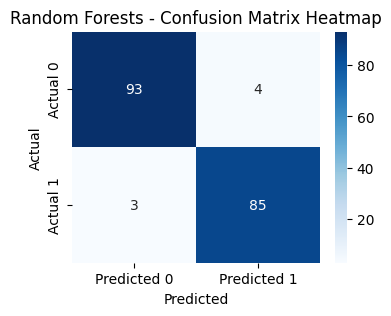

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forests - Confusion Matrix Heatmap')
plt.show()

#### Logistic Regression

In [26]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Logistic Regression Classifier
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy of Logistic Regression: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy of Logistic Regression: 0.9513513513513514
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        97
           1       0.94      0.95      0.95        88

    accuracy                           0.95       185
   macro avg       0.95      0.95      0.95       185
weighted avg       0.95      0.95      0.95       185



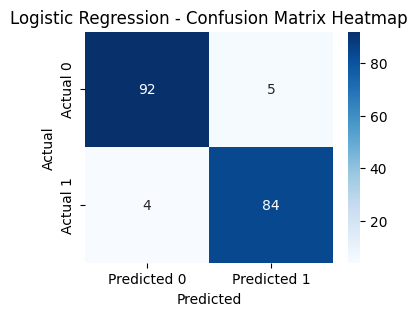

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression - Confusion Matrix Heatmap')
plt.show()

#### Decision Trees

In [31]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy of Decision Trees: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy of Decision Trees: 0.9405405405405406
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        97
           1       0.93      0.94      0.94        88

    accuracy                           0.94       185
   macro avg       0.94      0.94      0.94       185
weighted avg       0.94      0.94      0.94       185



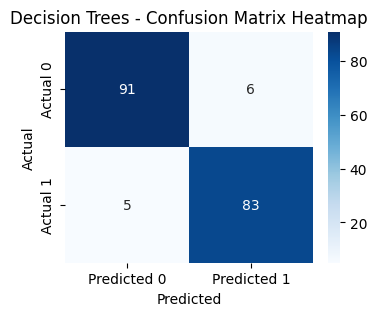

In [33]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Trees - Confusion Matrix Heatmap')
plt.show()

#### ANN (Artifical Neural Network)

In [36]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert target variable to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build the neural network
sequentialModel = Sequential()
sequentialModel.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
sequentialModel.add(Dense(32, activation='relu'))
sequentialModel.add(Dense(2, activation='softmax'))

# Compile the model
sequentialModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
sequentialModel.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)

# Evaluate the model
loss, accuracy = sequentialModel.evaluate(X_test, y_test, verbose=0)
y_pred = np.argmax(sequentialModel.predict(X_test), axis=1)
y_test_class = np.argmax(y_test, axis=1)

class_report = classification_report(y_test_class, y_pred)

print(f"Accuracy of ANN: {accuracy}")
print("Classification Report:")
print(class_report)

Epoch 1/50


C:\Users\HENNY PURWADI\.conda\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.6526 - loss: 0.6578
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.9436 - loss: 0.1928
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.9589 - loss: 0.1206
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.9686 - loss: 0.0969
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.9620 - loss: 0.1014
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.9631 - loss: 0.0970
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.9638 - loss: 0.0986
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.9617 - loss: 0.1092
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.9547 - loss: 0.1084
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.9704 - loss: 0.0836
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.9678 - loss: 0.1091
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy

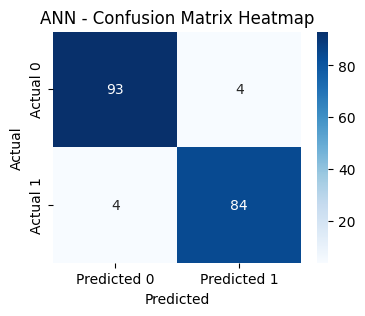

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_class, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANN - Confusion Matrix Heatmap')
plt.show()

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear')

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the performance of the classifier
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[134   4]
 [  8 132]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       138
           1       0.97      0.94      0.96       140

    accuracy                           0.96       278
   macro avg       0.96      0.96      0.96       278
weighted avg       0.96      0.96      0.96       278


Accuracy Score:
0.9568345323741008


In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [ ]:
# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred_best = best_model.predict(X_test)

print("\nBest Model Classification Report:")
print(classification_report(y_test, y_pred_best))

print("\nBest Model Accuracy Score:")
print(accuracy_score(y_test, y_pred_best))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1

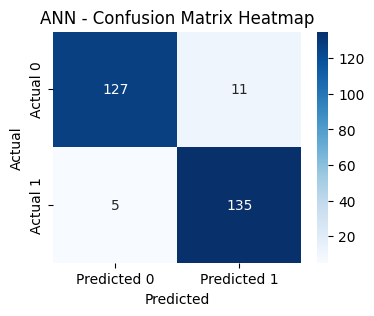

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANN - Confusion Matrix Heatmap')
plt.show()

### Accuracy

| Classifier                                                    | Accuracy              |
| ------------------------------------------------------------- | --------------------: |
| Accuracy of Random Forests                                    | 0.9621621621621622    |
| Accuracy of ANN			                                    | 0.9567567706108093    |
| Accuracy of Logistic Regression	                            | 0.9513513513513514    |
| Accuracy of SVM                                               | 0.9424460431654677    |
| Accuracy of Decision Trees	                                | 0.9405405405405406    |

We will use **Random Forests** as our classifier to fine-tune.

### Fine-tuning Random Forest

#### Cross-validation

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                            cv=3, n_jobs=4, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=2)

In [ ]:
# Evaluate the best model
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print(f'Train Accuracy: {grid_search.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {grid_search.score(X_test, y_test):.3f}')

Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy on Test Set: 0.9496402877697842
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       138
           1       0.95      0.95      0.95       140

    accuracy                           0.95       278
   macro avg       0.95      0.95      0.95       278
weighted avg       0.95      0.95      0.95       278

Train Accuracy: 0.978
Test Accuracy: 0.950


Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


### Visualizations

#### Feature Importance

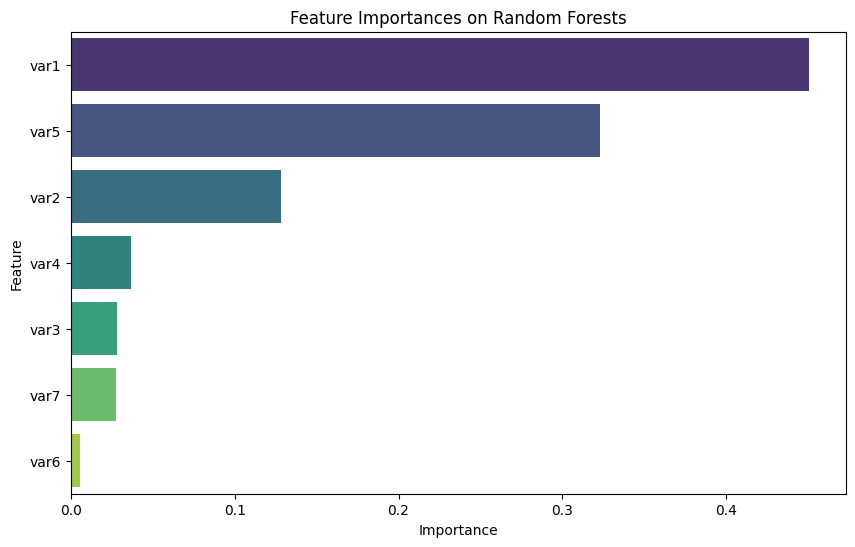

In [ ]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', dodge=False, palette='viridis')
plt.title('Feature Importances on Random Forests')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

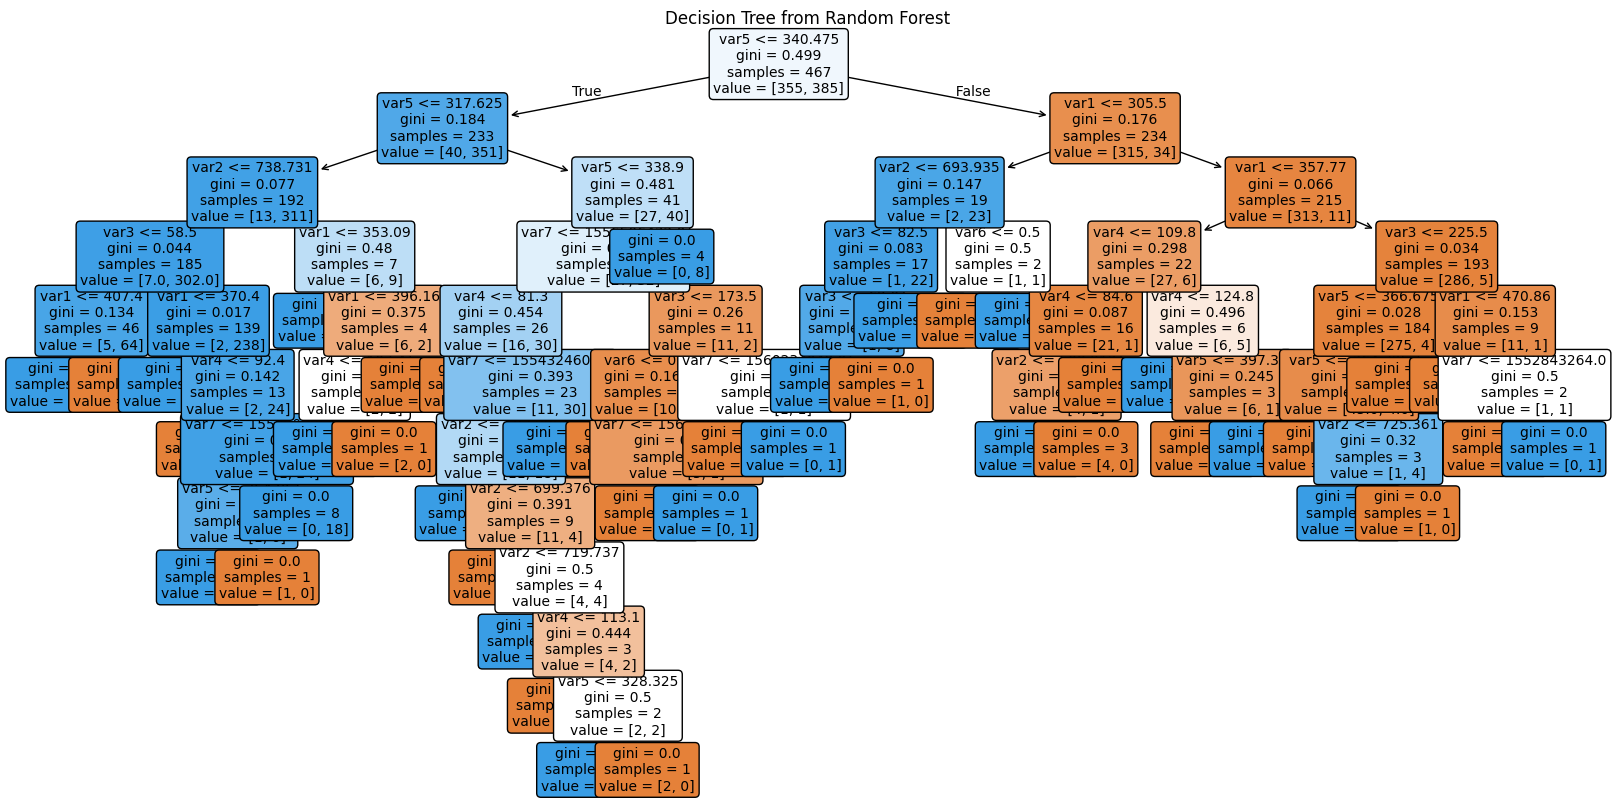

In [ ]:
# Get feature names
feature_names = X.columns

# Visualize one of the trees in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf_classifier.estimators_[0], feature_names=feature_names, filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree from Random Forest')
plt.show()

Limited Depth

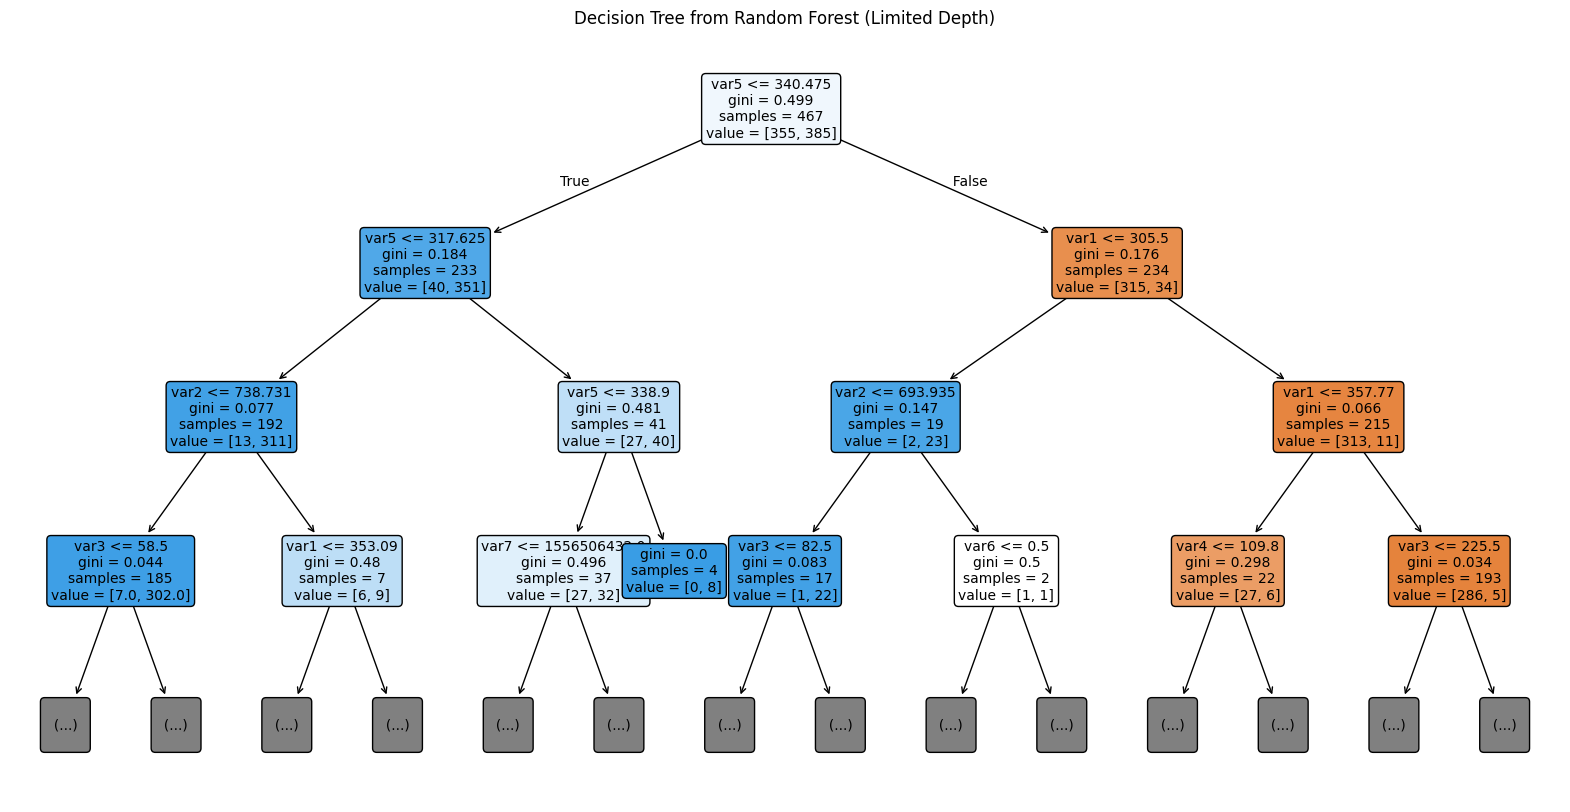

In [ ]:
# Visualize one of the trees in the forest with limited depth
plt.figure(figsize=(20, 10))
plot_tree(rf_classifier.estimators_[0], feature_names=feature_names, filled=True, rounded=True, fontsize=10, max_depth=3)
plt.title('Decision Tree from Random Forest (Limited Depth)')
plt.show()

#### Partial Dependence Plots (PDP)

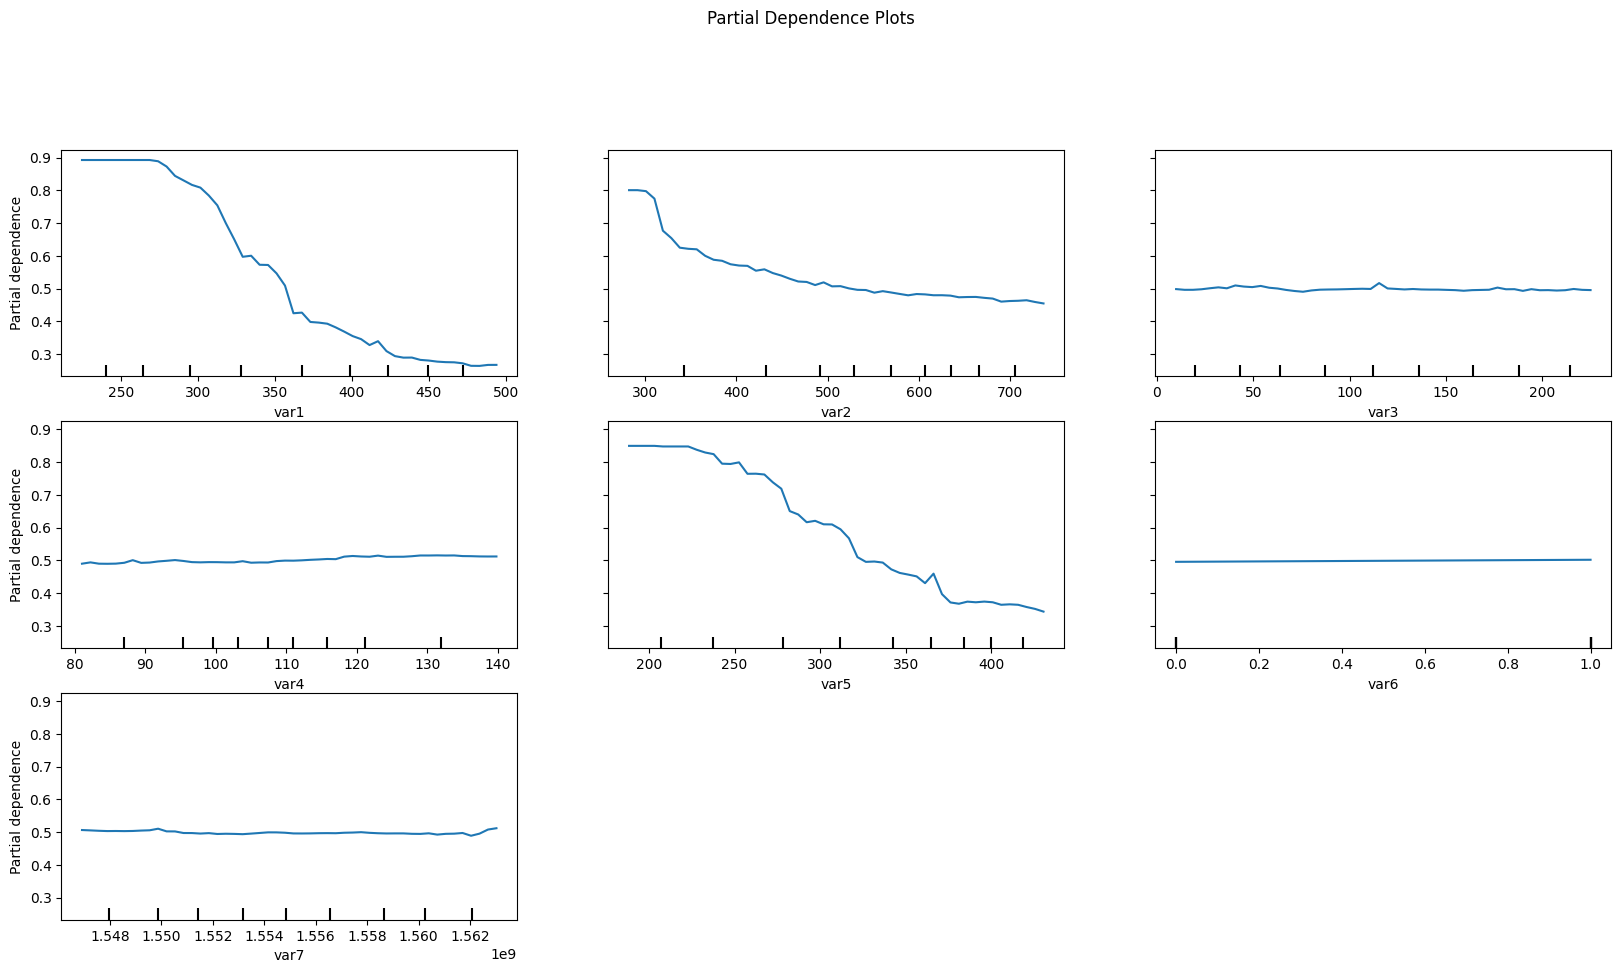

In [ ]:
# Create Partial Dependence Display
fig, ax = plt.subplots(figsize=(20, 10))
display = PartialDependenceDisplay.from_estimator(rf_classifier, X, feature_names, feature_names=feature_names, grid_resolution=50, ax=ax)
plt.suptitle('Partial Dependence Plots', y=1.02)
plt.show()

#### ROC Curve

Accuracy: 0.9621621621621622
Confusion Matrix:
 [[93  4]
 [ 3 85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96        97
           1       0.96      0.97      0.96        88

    accuracy                           0.96       185
   macro avg       0.96      0.96      0.96       185
weighted avg       0.96      0.96      0.96       185



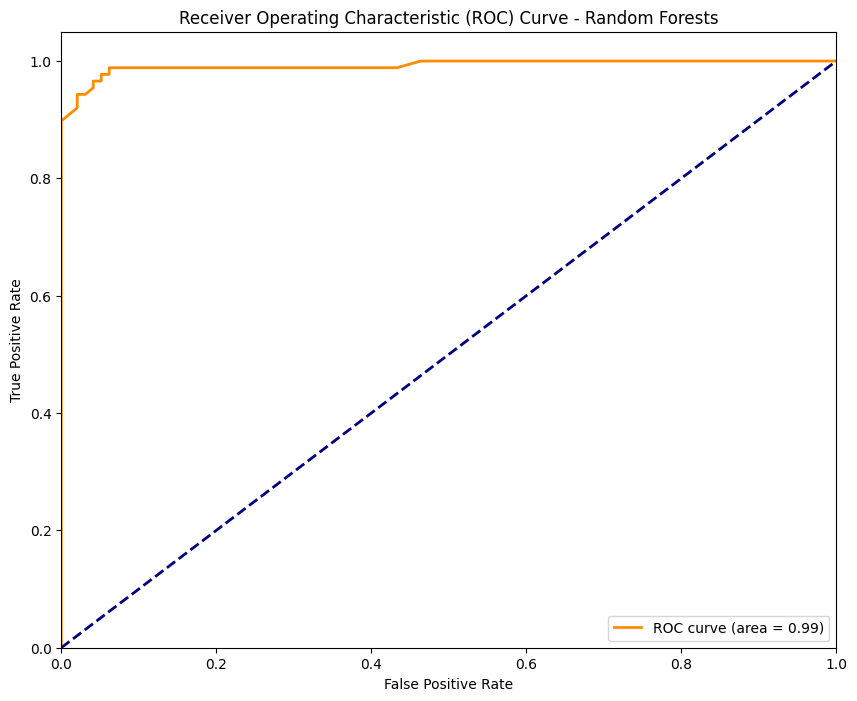

In [ ]:
# Check the classifier predictions and performance
y_pred = rf_classifier.predict(X_test)
y_score = rf_classifier.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Verify that predictions are not constant
unique_predictions = np.unique(y_pred)
if len(unique_predictions) == 1:
    print("Warning: The classifier is predicting a single class for all instances.")

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forests')
plt.legend(loc="lower right")
plt.show()


# **Dataset 2: Triple MNIST**

## Step-by-Step Guide to Build a CNN for Multi-Label Classification Problems:

### 1. Import Libraries and Function

Begin by importing all the required libraries and functions for data processing, model building, and evaluation.

### 2. Load the Dataset
Load the training, validation, and test datasets from the specified directories.

### 3. Preprocess the Dataset

- Reshape: Adjust the shape of the data to fit the model input requirements. In CNN need 4 dimensions of input shapes.
- Normalize Pixel Values: Scale the pixel values to the range [0, 1].
- Define Number of Categories: Specify the number of categories for each digit position.
- Flatten: Convert multi-dimensional arrays to a single dimension.
- Convert Labels to Categorical: Use one-hot encoding to convert labels for multi-label classification.
- Flatten Label Lists: Convert the label lists to dictionaries for multi-output models.
- Custom Data Generator: Define a custom data generator to yield batches of data during training.

### 4. Define Learning Rate and K-Fold Cross Validation
- Set up a learning rate scheduler to adjust the learning rate during training.
- Use K-fold cross-validation to better estimate model performance.

### 5. Set Up Callbacks for Early Stopping, and Model Checkpoint
Configure callbacks for early stopping, saving the best model, and logging training progress for visualization.
Implement early stopping to prevent overfitting by stopping training when the validation loss stops improving.

### 6. Define Function to Plot Learning Curves
Create a function to visualize training and validation accuracy and loss over epochs.

### 7. Define the CNN Model Architecture
Set Up the Input Shape. Build the CNN model architecture.
To be compared:
The last layer/ Output layer uses a sigmoid versus softmax.
The loss function uses categorical crossentropy versus binary crossentropy.

### 8. Train the Model
Train the model using the training data and validate it on the validation data, while using the defined callbacks.

### 9. Evaluate the Model
Evaluate the model and print the accuracy and loss metrics.

### 10. Perform Hyperparameter tuning 
- Perform 'keras-tuner' tuning to identify the best model parameters.
- Apply regularization techniques to prevent overfitting.
- Use cross-validation to obtain a more reliable estimate of the model's performance.

### 11. Re-Evaluate the Model
Re-Evaluate the model after Hyperparameter Tuning.

### 12. Final evaluation on the Test set
After finishing all the training and testing on the validation data, we trained the model one last time on all the training data. Then, we tested it on a completely new set of data that the model had never seen before (the Test set). This final evaluation checks how well the model performs on totally new data, making sure it’s ready for real life.

### 13. Visualization
After Final evaluation on the test set, we will visualize the results using a classification report, confusion matrix heatmaps, feature maps, Pydot, saliency map, Grad-CAM, Deep Dream Visualization, Guided Back Propagation Saliency map.

##  **1. Import necessary libraries and functions.**

In [1]:
%pip install -qqq tensorflow
%pip install -qqq keras-tuner
%pip install -qqq opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from PIL import Image

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from tensorflow.image import rgb_to_grayscale

from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import LambdaCallback

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore')

## **2. Load the Dataset**

In [3]:
def load_images_from_folder(folder, img_size=(28, 28)):
    
    """
    Loads grayscale images from a folder, processes them, and assigns labels based on subdirectory names.

    Args:
    folder (str): Path to the root folder containing subdirectories of images.
    img_size (tuple): Target size to resize images (height, width).

    Returns:
    tuple: A tuple containing two numpy arrays:
        - images (np.array): Array of processed image data.
        - labels (np.array): Array of labels corresponding to each image.
    """    
    
    images = []
    labels = []
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            label = [int(digit) for digit in subdir]  # the subdir name is the label
            for filename in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, filename)
                try:
                    img = Image.open(img_path).convert('L')
                    img = img.resize(img_size)
                    img = np.array(img)
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Failed to process image {img_path}: {e}")
    return np.array(images), np.array(labels)

In [4]:
# Define the directories
train_dir = r'dataset2/train'
test_dir = r'dataset2/test'
val_dir = r'dataset2/val'

print("Train directory contains:", os.listdir(train_dir))
print("Validation directory contains:", os.listdir(val_dir))
print("Test directory contains:", os.listdir(test_dir))

Train directory contains: ['000', '004', '005', '006', '007', '009', '011', '013', '015', '018', '020', '021', '022', '023', '024', '026', '027', '028', '030', '031', '032', '033', '034', '035', '036', '037', '038', '040', '041', '042', '043', '045', '048', '049', '050', '052', '054', '055', '057', '059', '061', '062', '063', '064', '066', '070', '071', '072', '074', '075', '078', '079', '080', '082', '084', '085', '089', '090', '091', '093', '094', '095', '097', '100', '101', '102', '103', '104', '105', '107', '110', '114', '115', '116', '117', '118', '119', '120', '121', '122', '124', '125', '127', '128', '131', '132', '134', '138', '142', '145', '147', '148', '150', '151', '153', '155', '156', '157', '159', '160', '161', '162', '163', '164', '165', '166', '167', '169', '170', '171', '172', '174', '175', '177', '178', '179', '181', '182', '183', '184', '185', '188', '189', '190', '191', '192', '195', '196', '199', '200', '201', '202', '203', '204', '205', '209', '210', '211', '212', 

In [5]:
# Load the datasets
X_train, y_train = load_images_from_folder(train_dir, img_size=(28, 28))
X_val, y_val = load_images_from_folder(val_dir, img_size=(28, 28))
X_test, y_test = load_images_from_folder(test_dir, img_size=(28, 28))

* In CNN, we need to define the input shape as 4 dimensions.
* Input shape (64000, 28, 28, 1) means 64,000 images of 28 by 28 pixels, not in color. (Black and White only).
* If in colors, input shape should be (64000, 28, 28, 3). The value 3 for Red, Green, and Blue.

In [7]:
X_train.shape

(64000, 28, 28, 1)

In [8]:
X_train.dtype

dtype('uint8')

In [9]:
X_train.min()

0

In [10]:
X_train.max()

255

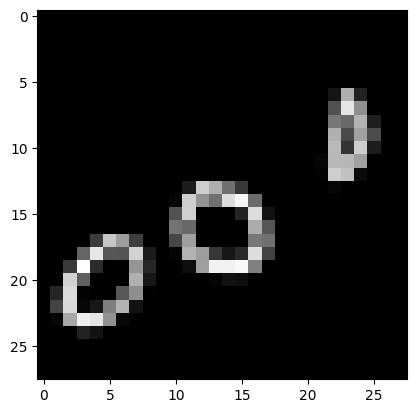

In [11]:
image = X_train[0]
plt.imshow(image, cmap = 'gray')

we can now see that this is a 28x28 pixel image of a 000. The answer is in the y_train data, which contains correct labels for the data.

In [13]:
y_train[0]

array([0, 0, 0])

In [14]:
X_test.shape

(20000, 28, 28, 1)

In [15]:
X_val.shape

(16000, 28, 28, 1)

In [16]:
# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
for i in range(3):
    print(f"y_train[{i}] shape: {y_train[i].shape}")

print(f"X_val shape: {X_val.shape}")
for i in range(3):
    print(f"y_val[{i}] shape: {y_val[i].shape}")
    
print(f"X_test shape: {X_test.shape}")
for i in range(3):
    print(f"y_test[{i}] shape: {y_test[i].shape}")

X_train shape: (64000, 28, 28, 1)
y_train[0] shape: (3,)
y_train[1] shape: (3,)
y_train[2] shape: (3,)
X_val shape: (16000, 28, 28, 1)
y_val[0] shape: (3,)
y_val[1] shape: (3,)
y_val[2] shape: (3,)
X_test shape: (20000, 28, 28, 1)
y_test[0] shape: (3,)
y_test[1] shape: (3,)
y_test[2] shape: (3,)


## **3. Preprocess the Dataset**

In [18]:
# Normalize pixel values to scale the pixel values to the range [0, 1].
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [19]:
# Ensure the images have the correct shape for CNN input
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [20]:
X_train.shape

(64000, 28, 28, 1)

We can now see that the values are all floating between 0.0 and 1.0 after Normalized

In [22]:
X_train.dtype

dtype('float32')

In [23]:
X_train.min()

0.0

In [27]:
X_train.max()

1.0

In [28]:
# Number of categories for each digit position
num_categories = 10

In [29]:
# Convert labels to categorical (one-hot encoding)
y_train = [to_categorical([label[i] for label in y_train], num_categories) for i in range(3)]
y_val = [to_categorical([label[i] for label in y_val], num_categories) for i in range(3)]
y_test = [to_categorical([label[i] for label in y_test], num_categories) for i in range(3)]

In [30]:
# Flatten the label lists to dictionaries
y_train_dict = {f'digit_{i}': y_train[i] for i in range(3)}
y_val_dict = {f'digit_{i}': y_val[i] for i in range(3)}
y_test_dict = {f'digit_{i}': y_test[i] for i in range(3)}

In [31]:
y_train

[array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]])]

In [32]:
# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
for i in range(3):
    print(f"y_train[{i}] shape: {y_train[i].shape}")

print(f"X_val shape: {X_val.shape}")
for i in range(3):
    print(f"y_val[{i}] shape: {y_val[i].shape}")

print(f"X_test shape: {X_test.shape}")
for i in range(3):
    print(f"y_test[{i}] shape: {y_test[i].shape}")

X_train shape: (64000, 28, 28, 1)
y_train[0] shape: (64000, 10)
y_train[1] shape: (64000, 10)
y_train[2] shape: (64000, 10)
X_val shape: (16000, 28, 28, 1)
y_val[0] shape: (16000, 10)
y_val[1] shape: (16000, 10)
y_val[2] shape: (16000, 10)
X_test shape: (20000, 28, 28, 1)
y_test[0] shape: (20000, 10)
y_test[1] shape: (20000, 10)
y_test[2] shape: (20000, 10)


In [33]:
y_train[0:9]

[array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]])]

In [34]:
y_train_dict

{'digit_0': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'digit_1': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'digit_2': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]])}

In [35]:
y_val_dict

{'digit_0': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'digit_1': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'digit_2': array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]])}

In [36]:
# Custom Data Generator
def custom_data_generator(X, y, batch_size):

    """
    A custom data generator that yields batches of data and corresponding labels
    in a randomized order.

    Args:
    X (array-like): The input data.
    y (dict of array-like): A dictionary of labels, where each key corresponds 
                            to a different set of labels.
    batch_size (int): The number of samples to include in each batch.

    Yields:
    tuple: A tuple containing a batch of input data and a dictionary of corresponding labels.
    """
    
    while True:
        idx = np.random.permutation(len(X))
        X = X[idx]
        y = {key: y[key][idx] for key in y}
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = {key: y[key][i:i + batch_size] for key in y}
            yield X_batch, y_batch

## **4. Define Learning Rate and K-Fold Cross Validation**

In [38]:
def lr_schedule(epoch):

    """
    A learning rate scheduler function that adjusts the learning rate based on the epoch.

    Args:
    epoch (int): The current epoch number.

    Returns:
    float: The adjusted learning rate.
    """
    
    lr = 1e-3
    if epoch > 20:
        lr *= 0.01
    elif epoch > 10:
        lr *= 0.1
    return lr

In [39]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

lr_scheduler = LearningRateScheduler(lr_schedule)

In [40]:
# K-Fold Cross Validation
kf = KFold(n_splits=2, shuffle=True)

k=2 to save time and resources.  With fewer folds, the training process will be faster because there are fewer iterations.

## **5. Set Up Callbacks for Early Stopping**
Configure callbacks for early stopping, saving the best model, and logging training progress for visualization in TensorBoard. Implement early stopping to prevent overfitting by stopping training when the validation loss stops improving.

In [43]:
# Callback for early stopping with adjusted patience.
# If the validation loss does not improve for 20 consecutive epochs, training will stop early.

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

The early stopping callback is used/ triggered to stop training early if the validation loss does not improve for a certain number of epochs (patience). 

## **6. Define Function to Plot Learning Curves**
Create a function to visualize training and validation accuracy and loss over epochs.

In [46]:
def plot_learning_curves(history):
    
    """
    Plots the learning curves for training and validation accuracy and loss.

    Args:
    history (tf.keras.callbacks.History): History object containing training metrics.

    Returns:
    None
    """
    
    acc = [history.history[f'digit_{i}_accuracy'] for i in range(3)]
    val_acc = [history.history[f'val_digit_{i}_accuracy'] for i in range(3)]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    for i in range(3):
        plt.plot(epochs, acc[i], label=f'Training accuracy digit_{i}')
        plt.plot(epochs, val_acc[i], label=f'Validation accuracy digit_{i}')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## 7/8/9. CNN Model with Activation: *_Sigmoid_*, Loss function: *_Categorical Cross Entropy_*

### 7A. Define the CNN Model

For multi-label classification, the last layer in the model should uses a sigmoid function for label prediction, and the training process should uses a binary_crossentropy function as the loss function. 

But for comparison purpose, we will use loss='categorical_crossentropy' function as the loss function first.

In [86]:
def create_cnn_model_sgcc():
    """
    Creates a CNN model for multi-label classification with three output layers.

    The model is designed for 28x28 grayscale images and uses Conv2D layers
    with MaxPooling, Dropout, and Dense layers. Each output layer predicts
    10 classes using the sigmoid activation function and categorical_crossentropy loss function.

    Returns:
    Model: A compiled Keras model.
    """    
    inputs = Input(shape=(28, 28, 1))  # Input shape for a 28x28 grayscale image
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = [Dense(10, activation='sigmoid', name=f'digit_{i}')(x) for i in range(3)]
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='categorical_crossentropy',  # usually categorical_crossentropy is for multi-class classification, not for multi-label classification.
        optimizer='adam',
        metrics={f'digit_{i}': 'accuracy' for i in range(3)}
    )
    return model

# Example usage
model = create_cnn_model_sgcc()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 26, 26, 32)        │             320 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 13, 13, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 13, 13, 32)        │               0 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 11, 11, 64)        │          18,496 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 5, 5, 64)          │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 5, 5, 64)          │               0 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 1600)              │               0 │ dropout_5[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 256)               │         409,856 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 256)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ digit_0 (Dense)               │ (None, 10)                │           2,570 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ digit_1 (Dense)               │ (None, 10)                │           2,570 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ digit_2 (Dense)               │ (None, 10)                │           2,570 │ dropout_6[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 436,382 (1.66 MB)

 Trainable params: 436,382 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

### 8A. Train the Model

In [ ]:
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold = {key: y_train_dict[key][train_index] for key in y_train_dict}
    y_val_fold = {key: y_train_dict[key][val_index] for key in y_train_dict}

    model = create_cnn_model_sgcc()  # Using CNN model instead of Dense model

    history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=128),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback]
    )

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - digit_0_accuracy: 0.1846 - digit_1_accuracy: 0.1818 - digit_2_accuracy: 0.1658 - loss: 6.8737 - val_digit_0_accuracy: 0.6576 - val_digit_1_accuracy: 0.7312 - val_digit_2_accuracy: 0.6023 - val_loss: 3.7390 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - digit_0_accuracy: 0.5968 - digit_1_accuracy: 0.6299 - digit_2_accuracy: 0.5100 - loss: 3.9484 - val_digit_0_accuracy: 0.8424 - val_digit_1_accuracy: 0.8701 - val_digit_2_accuracy: 0.7859 - val_loss: 2.4118 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - digit_0_accuracy: 0.7218 - digit_1_accuracy: 0.7494 - digit_2_accuracy: 0.6527 - loss: 3.0825 - val_digit_0_accuracy: 0.8796 - val_digit_1_accuracy: 0.8877 - val_digit_2_accuracy: 0.8275 - val_loss: 2.0441 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - digit_0_accuracy: 0.7703 - digit_1_accuracy: 0.7906 - digit_2_accuracy: 0.7100 - loss

### 9A. Evaluate The Model Performance

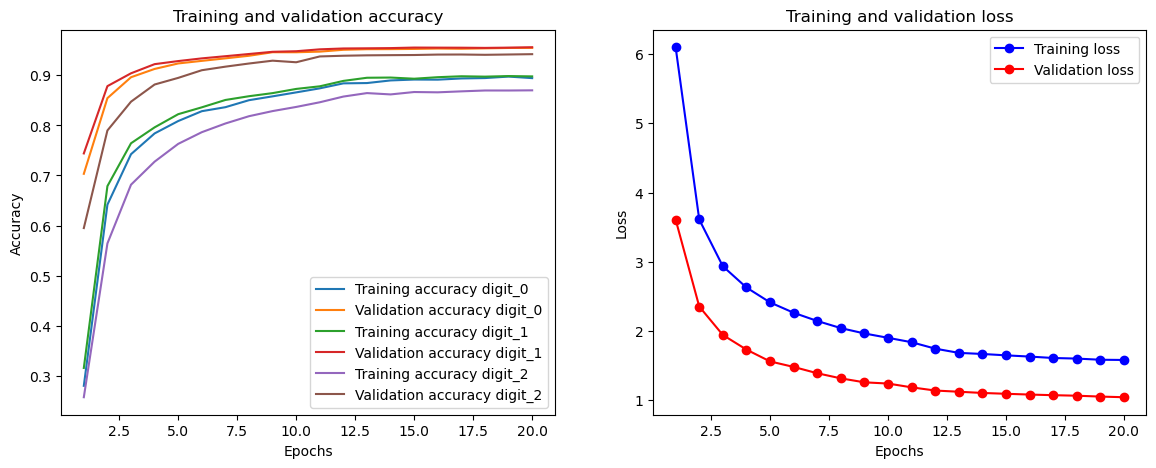

In [ ]:
# Plot learning curves for the last fold
plot_learning_curves(history)

### Interpretation

There is high accuracy on the training and validation set. Training and validation loss decreasing significantly. That means the model is good, not underfitting nor overfitting. The lowest loss using 'categorical-crossentropy' as the loss function is around  is around 1.5.

## 7/8/9. CNN Model with Activation: *_Sigmoid_*, Loss function: *_Binary Cross Entropy_*

### 7B. Define the CNN Model

For multi-label classification, the training process should uses a binary_crossentropy function as the loss function.

In [ ]:
def create_cnn_model_sgbc():
    
    """
    Creates a CNN model for multi-label classification with three output layers.

    The model is designed for 28x28 grayscale images and uses Conv2D layers
    with MaxPooling, Dropout, and Dense layers. Each output layer predicts
    10 classes using the sigmoid activation function and binary_crossentropy loss function.

    Returns:
    Model: A compiled Keras model.
    """
    
    inputs = Input(shape=(28, 28, 1))  # Input shape for a 28x28 grayscale image
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = [Dense(10, activation='sigmoid', name=f'digit_{i}')(x) for i in range(3)]
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='binary_crossentropy',  # Binary_crossentropy for multi-label classification
        optimizer='adam',
        metrics={f'digit_{i}': 'accuracy' for i in range(3)}
    )
    return model

# Example usage
model = create_cnn_model_sgbc()
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 26, 26,    │        320 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 13, 13,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 13, 13,    │          0 │ max_pooling2d_24… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 11, 11,    │     18,496 │ dropout_36[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 5, 5, 64)  │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 5, 5, 64)  │          0 │ max_pooling2d_25… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 1600)      │          0 │ dropout_37[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    409,856 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 256)       │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_0 (Dense)     │ (None, 10)        │      2,570 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_1 (Dense)     │ (None, 10)        │      2,570 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_2 (Dense)     │ (None, 10)        │      2,570 │ dropout_38[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 436,382 (1.66 MB)

 Trainable params: 436,382 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

### 8B. Train the Model

In [ ]:
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold = {key: y_train_dict[key][train_index] for key in y_train_dict}
    y_val_fold = {key: y_train_dict[key][val_index] for key in y_train_dict}

    model = create_cnn_model_sgbc()  # Using CNN model with 'binary_crossentropy' function as the loss function

    history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=128),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback]    )

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 98ms/step - digit_0_accuracy: 0.1043 - digit_1_accuracy: 0.1056 - digit_2_accuracy: 0.1031 - loss: 1.3526 - val_digit_0_accuracy: 0.2121 - val_digit_1_accuracy: 0.2536 - val_digit_2_accuracy: 0.1408 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - digit_0_accuracy: 0.2276 - digit_1_accuracy: 0.2232 - digit_2_accuracy: 0.1916 - loss: 0.9703 - val_digit_0_accuracy: 0.4298 - val_digit_1_accuracy: 0.4882 - val_digit_2_accuracy: 0.4065 - val_loss: 0.8317 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - digit_0_accuracy: 0.3769 - digit_1_accuracy: 0.4160 - digit_2_accuracy: 0.3430 - loss: 0.8572 - val_digit_0_accuracy: 0.5990 - val_digit_1_accuracy: 0.6433 - val_digit_2_accuracy: 0.5247 - val_loss: 0.7406 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - digit_0_accuracy: 0.4899 - digit_1_accuracy: 0.5131 - digit_2_accuracy: 0.4258 - loss:

### 9B. Evaluate The Model

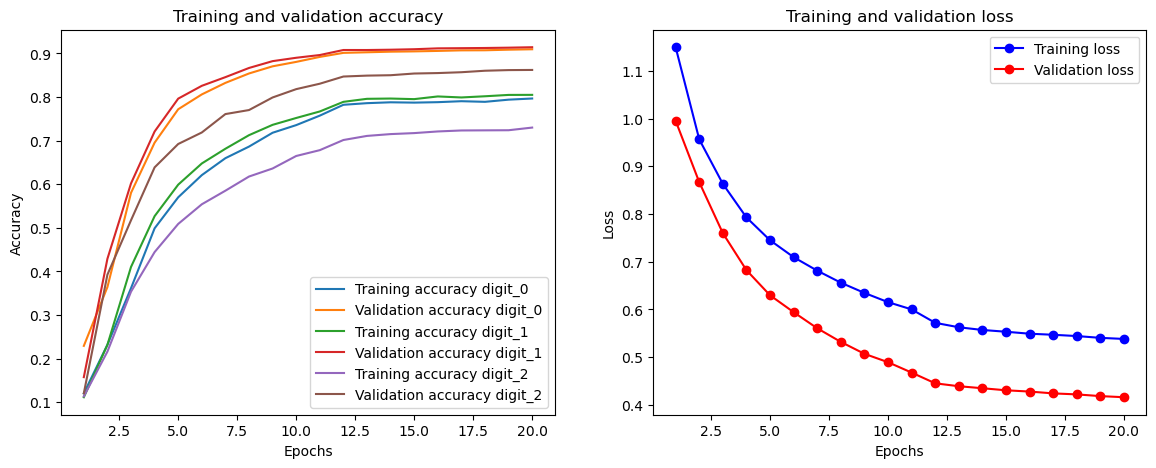

In [ ]:
# Plot learning curves for the last fold
plot_learning_curves(history)

### Interpretation

The model is on the right track. Both training loss and validation loss decreasing over time, which is good, although the accuracy for digit 2 (purple lines) is lower than for digits 0 and 1.

### Training and Validation Accuracy

Although the training accuracy is slightly higher than the validation accuracy, the gap between them is not very large. 
That means the model is not overfitting.

### Training and validation Loss

The loss for both training and validation decreases significantly in the first few epochs and then stabilized, decreasing slowly.

**The lowest loss using 'binary-crossentropy' as the loss function is around  is around 0.5, which is lower than loss using 'categorical-crossentropy' as the loss function.**

## 7/8/9. CNN Model with Activation: *_Softmax_*, Loss function: *_Binary Cross Entropy_*

### 7C. Define the Model

In [ ]:
def create_cnn_model_smaxbc():
    
    """
    Creates a CNN model for multi-class classification with three output layers.

    The model is designed for 28x28 grayscale images and uses Conv2D layers
    with MaxPooling, Dropout, and Dense layers. Each output layer predicts
    10 classes using the softmax activation function and binary_crossentropy loss function.

    Returns:
    Model: A compiled Keras model.
    """
    
    inputs = Input(shape=(28, 28, 1))  # Input shape for a 28x28 grayscale image
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = [Dense(10, activation='softmax', name=f'digit_{i}')(x) for i in range(3)]
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='binary_crossentropy',  # usually categorical_crossentropy is for multi-class classification, not for multi-label classification.
        optimizer='adam',
        metrics={f'digit_{i}': 'accuracy' for i in range(3)}
    )
    return model

model = create_cnn_model_smaxbc()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 26, 26, 32)        │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 13, 13, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 13, 13, 32)        │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 11, 11, 64)        │          18,496 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 5, 5, 64)          │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 5, 5, 64)          │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 1600)              │               0 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         409,856 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 256)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ digit_0 (Dense)               │ (None, 10)                │           2,570 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ digit_1 (Dense)               │ (None, 10)                │           2,570 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ digit_2 (Dense)               │ (None, 10)                │           2,570 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 436,382 (1.66 MB)

 Trainable params: 436,382 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

### 8C. Train the Model

In [ ]:
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold = {key: y_train_dict[key][train_index] for key in y_train_dict}
    y_val_fold = {key: y_train_dict[key][val_index] for key in y_train_dict}

    model = create_cnn_model_smaxbc()  # Using CNN model with 'binary_crossentropy' function as the loss function

    history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=128),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback]    )

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - digit_0_accuracy: 0.1033 - digit_1_accuracy: 0.1048 - digit_2_accuracy: 0.1089 - loss: 1.3573 - val_digit_0_accuracy: 0.2137 - val_digit_1_accuracy: 0.1956 - val_digit_2_accuracy: 0.1765 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - digit_0_accuracy: 0.2014 - digit_1_accuracy: 0.2048 - digit_2_accuracy: 0.1708 - loss: 0.9808 - val_digit_0_accuracy: 0.3822 - val_digit_1_accuracy: 0.4486 - val_digit_2_accuracy: 0.3723 - val_loss: 0.8628 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - digit_0_accuracy: 0.3276 - digit_1_accuracy: 0.3855 - digit_2_accuracy: 0.3239 - loss: 0.8800 - val_digit_0_accuracy: 0.5558 - val_digit_1_accuracy: 0.5997 - val_digit_2_accuracy: 0.4953 - val_loss: 0.7669 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - digit_0_accuracy: 0.4537 - digit_1_accuracy: 0.4930 - digit_2_accuracy: 0.4058 - loss:

### 9C. Evaluate the model

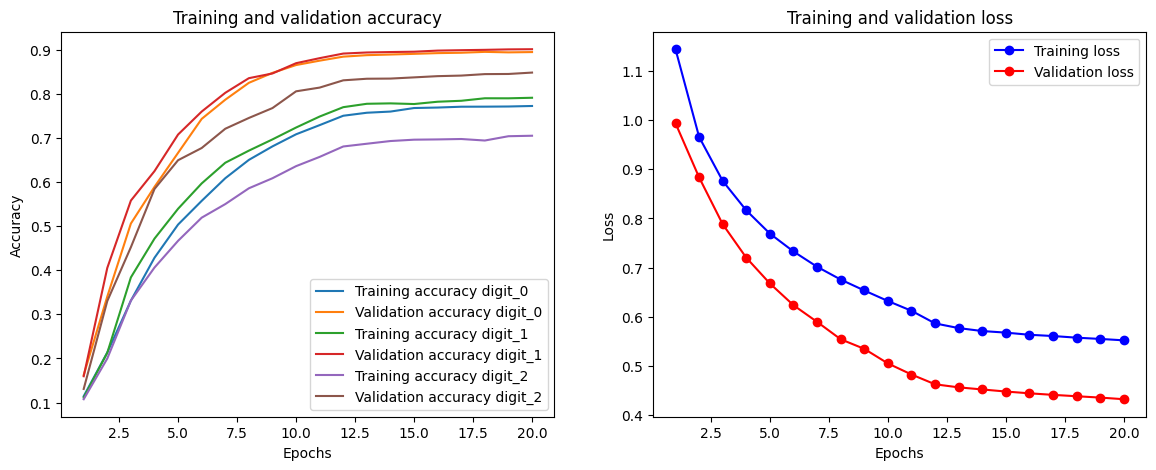

In [ ]:
# Plot learning curves for the last fold
plot_learning_curves(history)

### Next Plan

* Increase Model Complexity: Consider adding more layers or units to the model, especially to increase accuracy for digit 2 (purple lines).
* Hyperparameter Tuning: Experiment with different learning rates, batch sizes, and regularization techniques. Increase fold number. With more folds, the validation estimate is more robust and less variable and better Generalization.
* Using Batch Normalization to normalize the inputs to a layer for each mini-batch, to reduce the internal covariate shift.

The model is good, but requires further tuning and possibly a more complex architecture to improve its performance.

## 10. Hyperparameter Tuning
- Perform 'keras-tuner' tuning to identify the best model parameters.
- Apply regularization techniques to prevent overfitting.
- Use cross-validation to obtain a more reliable estimate of the model's performance. 
- Use batch Normalization to normalize the inputs to a layer for each mini-batch. This reduces the internal covariate shift.

## Using Keras Tuner to optimize the CNN hypermodel and setting up a tuner to find the best hyperparameters.

In [ ]:
def build_model(hp):
    
    """
    Builds a CNN model with hyperparameter tuning for multi-class classification with three output layers.

    The model is designed for 28x28 grayscale images and uses Conv2D layers
    with BatchNormalization, MaxPooling, Dropout, and Dense layers. Each output
    layer predicts 10 classes using the softmax activation function.

    Args:
    hp (HyperParameters): Hyperparameters for tuning.

    Returns:
    Model: A compiled Keras model.
    """
    
    inputs = Input(shape=(28, 28, 1))
    
    # First Convolutional Block
    x = Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=l2(0.001)
    )(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Second Convolutional Block
    x = Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=l2(0.001)
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Third Convolutional Block
    x = Conv2D(
        filters=hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=l2(0.001)
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation='relu',
        kernel_regularizer=l2(0.001)
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Output Layers
    outputs = [Dense(10, activation='softmax', name=f'digit_{i}')(x) for i in range(3)]
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        loss={'digit_0': 'binary_crossentropy', 'digit_1': 'binary_crossentropy', 'digit_2': 'binary_crossentropy'},
        optimizer='adam',
        metrics={'digit_0': 'accuracy', 'digit_1': 'accuracy', 'digit_2': 'accuracy'}
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cnn_hyperparameter_tuning'
)

# Perform hyperparameter search
tuner.search(
    custom_data_generator(X_train, y_train_dict, batch_size=32),
    epochs=20,
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_val, y_val_dict),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print summary of the best model and hyperparameters
print(best_hyperparameters.values)

Trial 20 Complete [00h 22m 29s]
val_loss: 0.07059618085622787

Best val_loss So Far: 0.06173119693994522
Total elapsed time: 05h 47m 46s
 
{'conv_1_filters': 96, 'conv_2_filters': 128, 'conv_3_filters': 128, 'dense_units': 256}


### Create CNN Model using the best hyperparameters obtained from the tuning process

#### The optimal parameters, based on Keras Tuner, are:

{'conv_1_filters': 96, 'conv_2_filters': 128, 'conv_3_filters': 128, 'dense_units': 256}

In [48]:
def create_cnn_model_smaxbch():

    """
    Creates a CNN model with specified hyperparameters for multi-label classification
    with three output layers. The model is designed for 28x28 grayscale images and
    uses Conv2D layers with BatchNormalization, MaxPooling, Dropout, and Dense layers.
    Each output layer predicts 10 classes using the sigmoid activation function.

    Returns:
    Model: A compiled Keras model.
    """

    inputs = Input(shape=(28, 28, 1))  # Input shape for a 28x28 grayscale image
    
    # First Convolutional Block with best hyperparameters
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Second Convolutional Block with best hyperparameters
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Third Convolutional Block with best hyperparameters
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Fully Connected Layers with best hyperparameters
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output Layers
    outputs = [Dense(10, activation='sigmoid', name=f'digit_{i}')(x) for i in range(3)]
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compiling the model
    model.compile(
        loss={'digit_0': 'binary_crossentropy', 'digit_1': 'binary_crossentropy', 'digit_2': 'binary_crossentropy'},
        optimizer='adam',
        metrics={'digit_0': 'accuracy', 'digit_1': 'accuracy', 'digit_2': 'accuracy'}
    )
    
    return model

model = create_cnn_model_smaxbch()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        960 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        384 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ max_pooling2d[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │    110,720 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 7, 128) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │    147,584 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3, 3, 128) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    295,168 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_0 (Dense)     │ (None, 10)        │      2,570 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_1 (Dense)     │ (None, 10)        │      2,570 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 564,574 (2.15 MB)

 Trainable params: 563,358 (2.15 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [111]:
# Increase K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True)

### Tuned model using SoftMax activation and Binary Cross Entropy loss function, with metrics tracked using LambdaCallback.

In [49]:
def print_metrics(epoch, logs):
    print(f"Epoch {epoch+1}: Loss = {logs['loss']:.4f}, Accuracy Digit 0 = {logs['digit_0_accuracy']:.4f}, "
          f"Accuracy Digit 1 = {logs['digit_1_accuracy']:.4f}, Accuracy Digit 2 = {logs['digit_2_accuracy']:.4f}")

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold = {key: y_train_dict[key][train_index] for key in y_train_dict}
    y_val_fold = {key: y_train_dict[key][val_index] for key in y_train_dict}

    model = create_cnn_model_smaxbch()  # Using CNN model using the best hyperparameters obtained from the tuning process

    # The LambdaCallback from Keras is used to create a callback that calls print_metrics at the end of each epoch. 
    print_callback = LambdaCallback(on_epoch_end=print_metrics)

    history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=32),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback, print_callback]
    )

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - digit_0_accuracy: 0.2297 - digit_1_accuracy: 0.2275 - digit_2_accuracy: 0.2292 - loss: 2.0716Epoch 1: Loss = 1.3337, Accuracy Digit 0 = 0.4725, Accuracy Digit 1 = 0.4660, Accuracy Digit 2 = 0.4642
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - digit_0_accuracy: 0.2299 - digit_1_accuracy: 0.2278 - digit_2_accuracy: 0.2294 - loss: 2.0709 - val_digit_0_accuracy: 0.9151 - val_digit_1_accuracy: 0.8928 - val_digit_2_accuracy: 0.8610 - val_loss: 0.5035 - learning_rate: 0.0010
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - digit_0_accuracy: 0.9075 - digit_1_accuracy: 0.9055 - digit_2_accuracy: 0.9036 - loss: 0.4415Epoch 2: Loss = 0.3999, Accuracy Digit 0 = 0.9175, Accuracy Digit 1 = 0.9138, Accuracy Digit 2 = 0.9128
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - digit_0_accuracy: 0.9075 - digit_1_accuracy: 0.9055 - digit_2_accuracy: 0.9036 - loss: 0.4414 - val_digit_0_accuracy: 0.8833 - val_digit_1_accuracy: 0.9234 - val_digit_

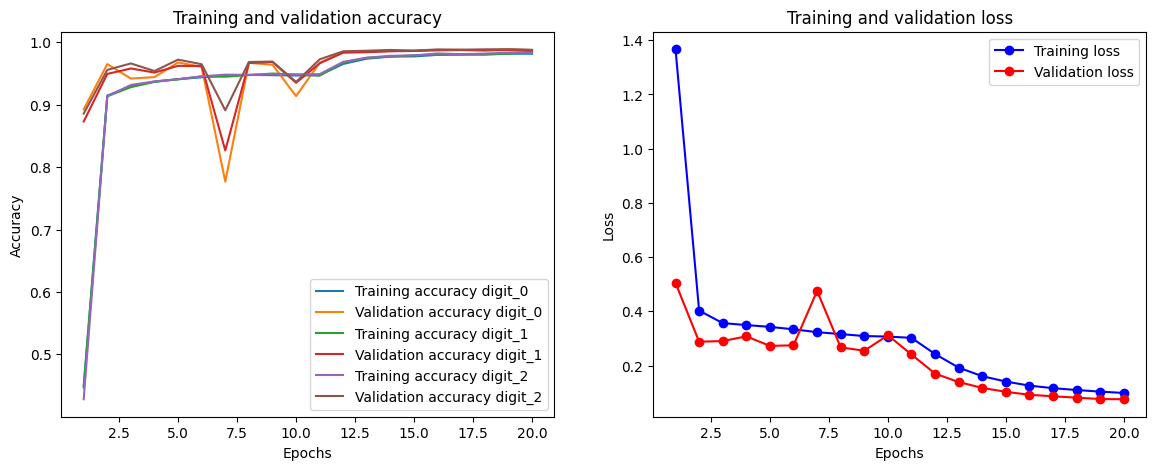

In [50]:
# Plot learning curves for the last fold
plot_learning_curves(history)

### Interpretation

There are some fluctuations in the early epochs, but overall, the training and validation accuracies are close to each other. 
The model is showing improvement and better performance after hyperparameter tuning. Both training and validation accuracies are higher, and losses are lower.

After Hyperparameter Tuning on SoftMax activation function and Binary Cross Entropy as the loss function achieved the model's highest accuracy (around 0.98).


## 11. Re-Evaluate The Model

### Training and Validation Accuracy

* The training accuracy has gotten better and keeps going up more than 96%. It means the model is learning more about the digits.
* The validation accuracy is also getting better and follows the training accuracy closely. This means the model isn’t just memorizing the training data but is also good at predicting new data. The validation accuracy goes up to about the same level as the training accuracy, which is great because it shows there’s no overfitting.

### Training and validation Loss

* The training loss keeps going down, showing the model is making fewer mistakes on the training data.
* There’s a drop around epoch 2-3. After that, the loss keeps going down but a bit slower.
* The validation loss is also going down and matches the training loss trend. This means the model is doing better on new data too.
* The validation loss is close to the training loss, which is good, because it means the model is not overfitting.

The lowest loss using _Binary Cross Entropy_ as the loss function is around  is around 0.1, which is lower than loss using _Categorical Cross Entropy_ as the loss function.

### Interpretation

The model achieves the ***highest accuracy on the test set*** when using the ***Softmax activation function and binary crossentropy for the loss function***, as opposed to using the sigmoid activation function with the same loss function.

The optimal parameters, based on Keras Tuner, are:

```{'conv_1_filters': 96, 'conv_2_filters': 128, 'conv_3_filters': 128, 'dense_units': 256}```

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 31500), started 6 days, 23:59:43 ago. (Use '!kill 31500' to kill it.)

## 12. Final evaluation on the test set using CNN model with Activation: _Softmax_, Loss function: _Binary Cross Entropy_

In [51]:
# Final evaluation on the test set Using CNN model with Softmax activation function and binary crossentropy
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold = {key: y_train_dict[key][train_index] for key in y_train_dict}
    y_val_fold = {key: y_train_dict[key][val_index] for key in y_train_dict}

model = create_cnn_model_smaxbch()   

history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=256),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 256,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback]    )

# Evaluate the model on the test set
test_metrics = model.evaluate(X_test, y_test_dict)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1:]

print(f'Test loss: {test_loss}')
for i, acc in enumerate(test_accuracy):
    print(acc)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 295ms/step - digit_0_accuracy: 0.1217 - digit_1_accuracy: 0.1203 - digit_2_accuracy: 0.1163 - loss: 3.1338 - val_digit_0_accuracy: 0.1013 - val_digit_1_accuracy: 0.0941 - val_digit_2_accuracy: 0.1032 - val_loss: 1.7790 - learning_rate: 0.0010
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 290ms/step - digit_0_accuracy: 0.2906 - digit_1_accuracy: 0.2633 - digit_2_accuracy: 0.2456 - loss: 1.4672 - val_digit_0_accuracy: 0.1044 - val_digit_1_accuracy: 0.0942 - val_digit_2_accuracy: 0.1055 - val_loss: 1.5670 - learning_rate: 0.0010
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - digit_0_accuracy: 0.7691 - digit_1_accuracy: 0.7701 - digit_2_accuracy: 0.7488 - loss: 0.8055 - val_digit_0_accuracy: 0.0772 - val_digit_1_accuracy: 0.1019 - val_digit_2_accuracy: 0.1056 - val_loss: 1.5693 - learning_rate: 0.0010
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 308ms/step - digit_0_accuracy: 0.9187 - digit_1_accuracy: 0.9210 - digit_2_accuracy: 0.9196 - l

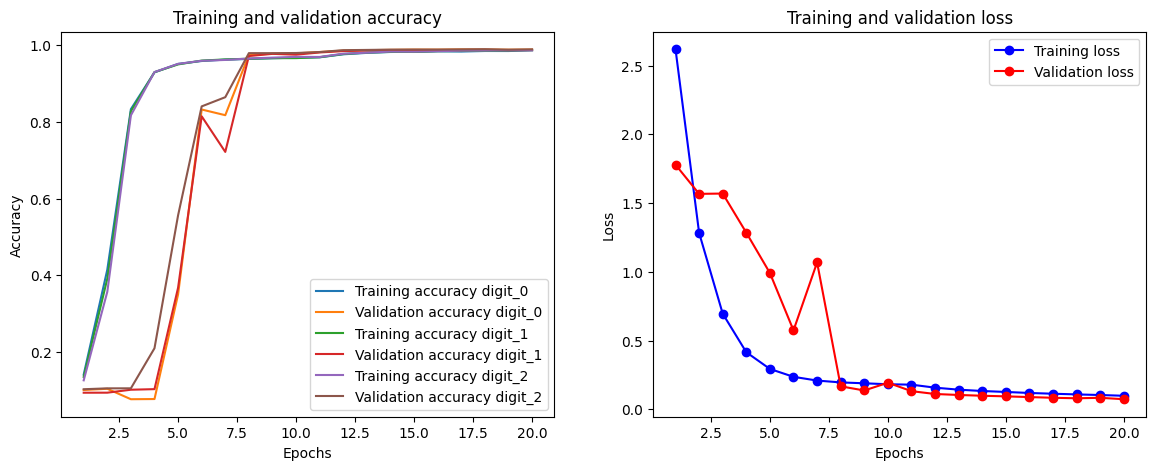

In [86]:
# Plot learning curves for the last fold
plot_learning_curves(history)

### **Interpretation:**

There is high accuracy on the test set (around 98%) and lowest loss (around 0.07), which the tuned model has never seen before, which means the tuned model can predict on the new unseen data. 748

## Save the trained model, load it, and then use it to predict one image from the test set

Train and save the model.

Load the saved model.

Predict a single image from the test set.

In [52]:
# Save the final model trained on the entire dataset
model.save('cnn_model_smaxbch_final.h5')

# Load the saved final model
model = load_model('cnn_model_smaxbch_final.h5')

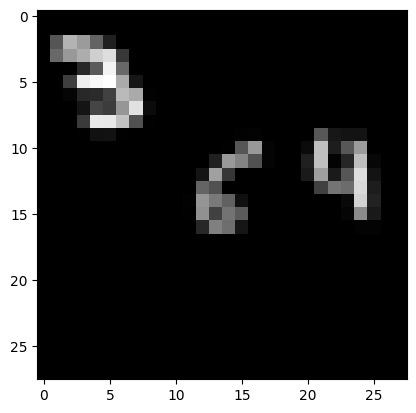

In [53]:
# Predict one image from the test dataset
test_image = X_test[7500]
test_image_expanded = np.expand_dims(test_image, axis=0)  # Add batch dimension
plt.imshow(test_image, cmap = 'gray')

In [54]:
prediction = model.predict(test_image_expanded)
predicted_labels = [np.argmax(pred) for pred in prediction]
print(f"Predicted Labels for the test image: {predicted_labels}")
print("\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Predicted Labels for the test image: [3, 6, 4]




## 13. Visualization

### Classification report for each digit

In [65]:
# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions to label indices
y_pred_indices = [np.argmax(y, axis=1) for y in y_pred]
y_test_indices = [np.argmax(y, axis=1) for y in y_test_dict.values()]

# Define class names (digits 0-9)
class_names = [str(i) for i in range(10)] 

for i in range(3):
    print(f"Classification Report for digit_{i}:")
    print(classification_report(y_test_indices[i], y_pred_indices[i], target_names=class_names))    

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Classification Report for digit_0:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2500
           1       0.99      0.99      0.99      1800
           2       0.98      0.99      0.99      1600
           3       0.99      0.99      0.99      2500
           4       0.99      0.99      0.99      2900
           5       0.98      0.98      0.98      1800
           6       0.98      0.99      0.99      1400
           7       0.99      0.99      0.99      1600
           8       0.98      0.98      0.98      2400
           9       0.97      0.97      0.97      1500

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000

Classification Report for digit_1:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1600
           1       1.

### Confusion Matrix

In [67]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    
    """
    Plots a confusion matrix using a heatmap.

    Args:
    cm (array-like): Confusion matrix.
    classes (list): List of class names.
    title (str, optional): Title of the confusion matrix. Defaults to 'Confusion matrix'.
    cmap (Colormap, optional): Colormap to be used in the heatmap. Defaults to plt.cm.Blues.

    Returns:
    None
    """
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#### Confusion matrix for each digit

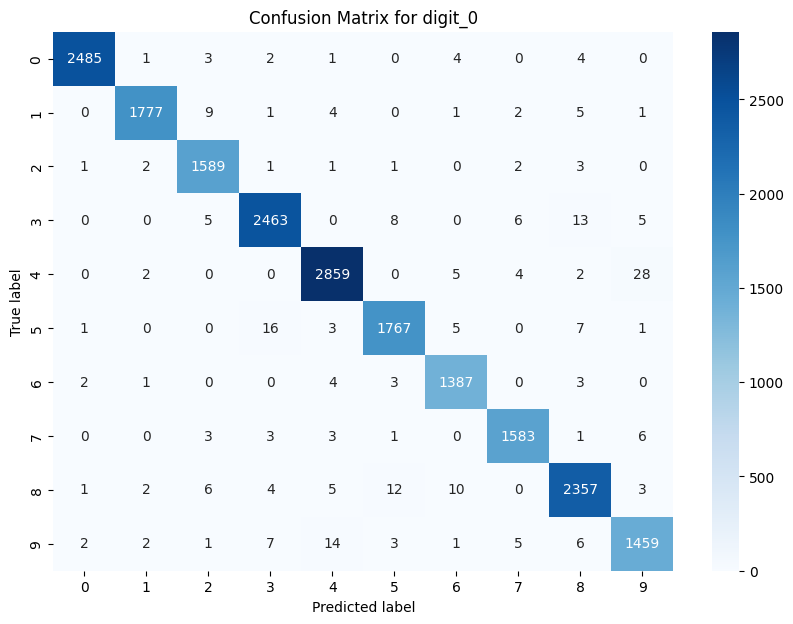

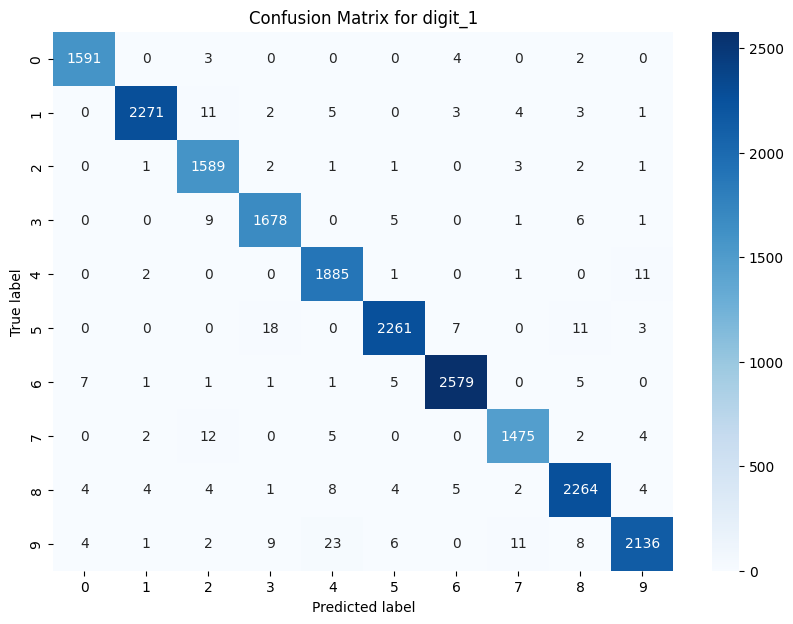

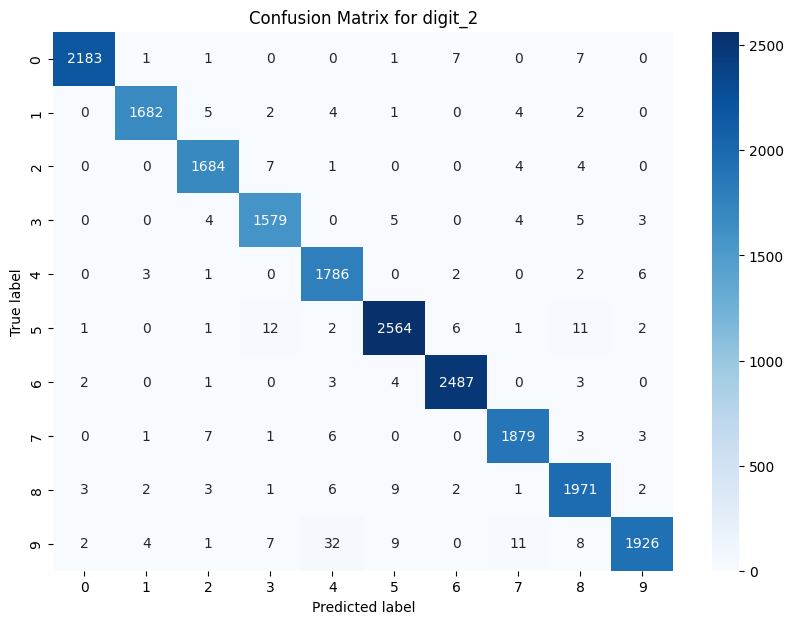

In [70]:
for i in range(3):    
    cm = confusion_matrix(y_test_indices[i], y_pred_indices[i])
    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for digit_{i}')

### Normalized Confusion Matrix

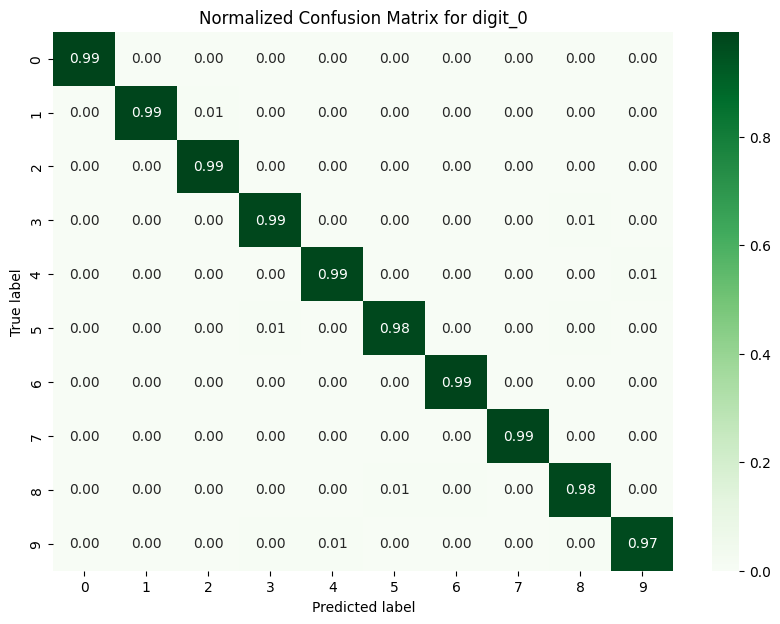

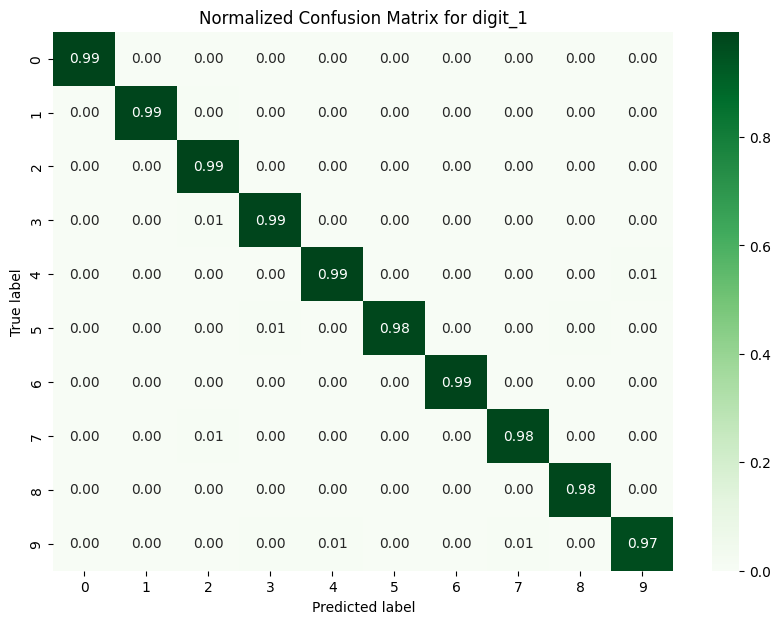

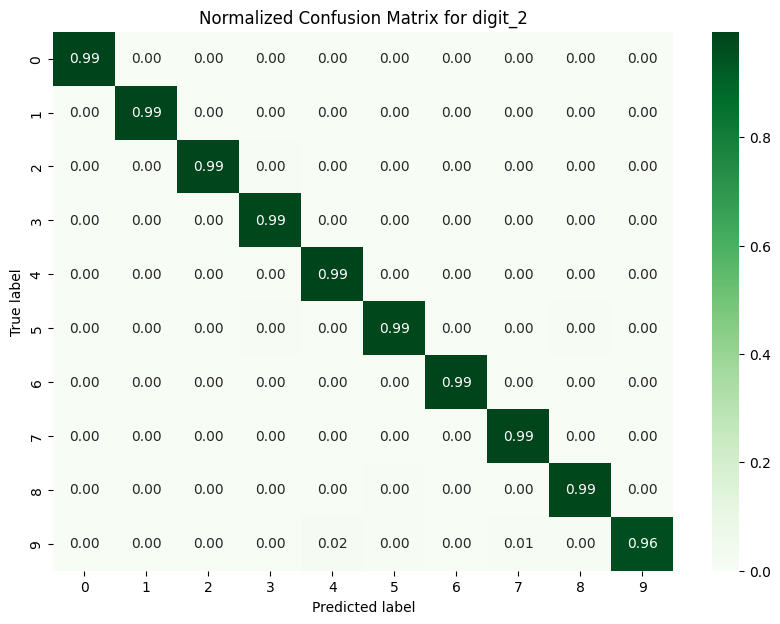

In [79]:
# Function to plot normalized confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot normalized confusion matrices for each digit
for i in range(3):    
    cm = confusion_matrix(y_test_indices[i], y_pred_indices[i], normalize='true')
    plot_confusion_matrix(cm, classes=class_names, title=f'Normalized Confusion Matrix for digit_{i}')


### Feature Maps Visualization

In [39]:
def build_model_for_feature_maps(input_shape, num_classes, conv_1_filters, conv_2_filters, conv_3_filters, dense_units, dropout_rate=0.5):
    
    """
    Builds a CNN model for classification with specified hyperparameters to visualize the feature maps.

    Args:
    input_shape (tuple): Shape of the input data (height, width, channels).
    num_classes (int): Number of output classes.
    conv_1_filters (int): Number of filters in the first convolutional layer.
    conv_2_filters (int): Number of filters in the second convolutional layer.
    conv_3_filters (int): Number of filters in the third convolutional layer.
    dense_units (int): Number of units in the dense layer.
    dropout_rate (float, optional): Dropout rate. Defaults to 0.5.
    learning_rate (float, optional): Learning rate for the optimizer. Defaults to 0.001.

    Returns:
    Model: A compiled Keras Functional model.
    """
    
    inputs = Input(shape=input_shape)
    
    # First convolutional layer
    x = Conv2D(filters=conv_1_filters, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Second convolutional layer
    x = Conv2D(filters=conv_2_filters, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Third convolutional layer
    x = Conv2D(filters=conv_3_filters, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    
    # Dense layer
    x = Dense(units=dense_units, activation='relu')(x)
    x = Dropout(rate=dropout_rate)(x)
    
    outputs = Dense(units=num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
    
    return model 


In [40]:
# Set optimal hyperparameters
input_shape = (28, 28, 1)
num_classes = 10
optimal_params = {
    'conv_1_filters': 96,
    'conv_2_filters': 128,
    'conv_3_filters': 128,
    'dense_units': 256
}

# Build and summarize the model
model_for_feature_maps = build_model_for_feature_maps(
    input_shape=input_shape,
    num_classes=num_classes,
    conv_1_filters=optimal_params['conv_1_filters'],
    conv_2_filters=optimal_params['conv_2_filters'],
    conv_3_filters=optimal_params['conv_3_filters'],
    dense_units=optimal_params['dense_units']
)
model_for_feature_maps.summary()
history = model_for_feature_maps.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,858 (1.12 MB)

 Trainable params: 294,858 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 53s 26ms/step - accuracy: 0.3985 - loss: 0.2494 - val_accuracy: 0.9022 - val_loss: 0.0522
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.9050 - loss: 0.0523 - val_accuracy: 0.9254 - val_loss: 0.0395
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - accuracy: 0.9347 - loss: 0.0374 - val_accuracy: 0.9326 - val_loss: 0.0361
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - accuracy: 0.9449 - loss: 0.0308 - val_accuracy: 0.9393 - val_loss: 0.0331
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step - accuracy: 0.9513 - loss: 0.0268 - val_accuracy: 0.9372 - val_loss: 0.0331
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.9610 - loss: 0.0218 - val_accuracy: 0.9439 - val_loss: 0.0315
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step - accuracy: 0.9649 - loss: 0.0198 - val_accuracy: 0.9441 - val_loss: 0.0313
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - accuracy: 0.9676 -

In [41]:
def plot_convolutional_layer_filters(filters, columns=8, rows=8, channel=0):
    
    """
    Plot filters from a convolutional layer.

    Parameters:
    filters (numpy.ndarray): The filters to be visualized, expected shape (filter_height, filter_width, input_channels, num_filters).
    columns (int): Number of columns in the plot grid. Default is 8.
    rows (int): Number of rows in the plot grid. Default is 8.
    channel (int): The channel of the filter to be visualized. Default is 0.
    """
    
    fig1 = plt.figure(figsize=(columns * 2, rows * 2))  # Adjust figure size based on the number of rows and columns
    n_filters = min(columns * rows, filters.shape[3])

    for i in range(1, n_filters + 1):
        f = filters[:, :, :, i - 1]

        ax = fig1.add_subplot(rows, columns, i)
        ax.set_xticks([])  # Turn off axis
        ax.set_yticks([])

        plt.imshow(f[:, :, channel], cmap='gray')
        ax.set_title(f'Filter {i}', fontsize=8)

    plt.tight_layout()
    plt.show()

Layer name: conv2d_3, Filters shape: (3, 3, 1, 96), Biases shape: (96,)


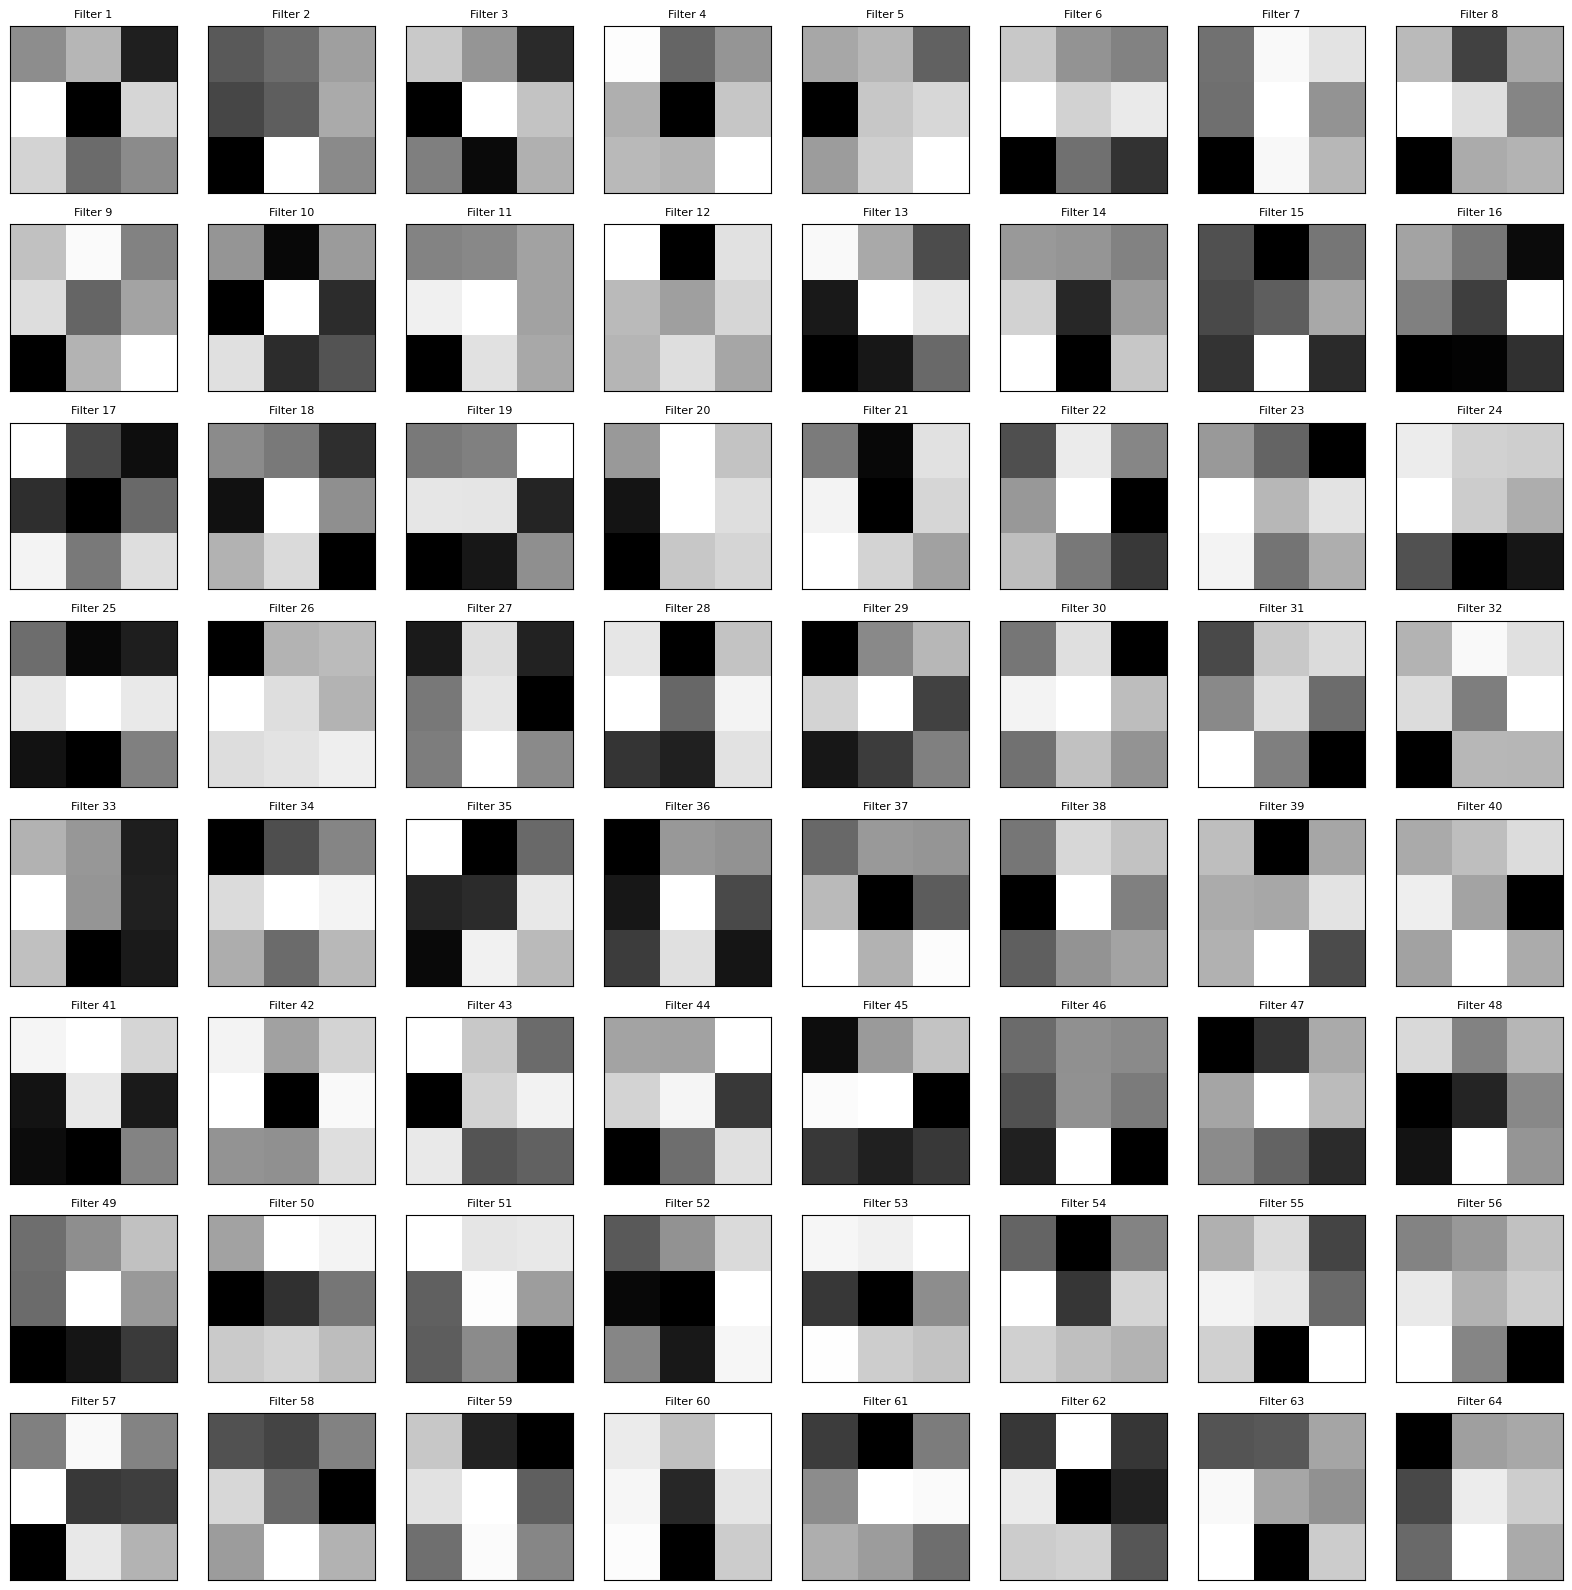

Layer name: conv2d_4, Filters shape: (3, 3, 96, 128), Biases shape: (128,)


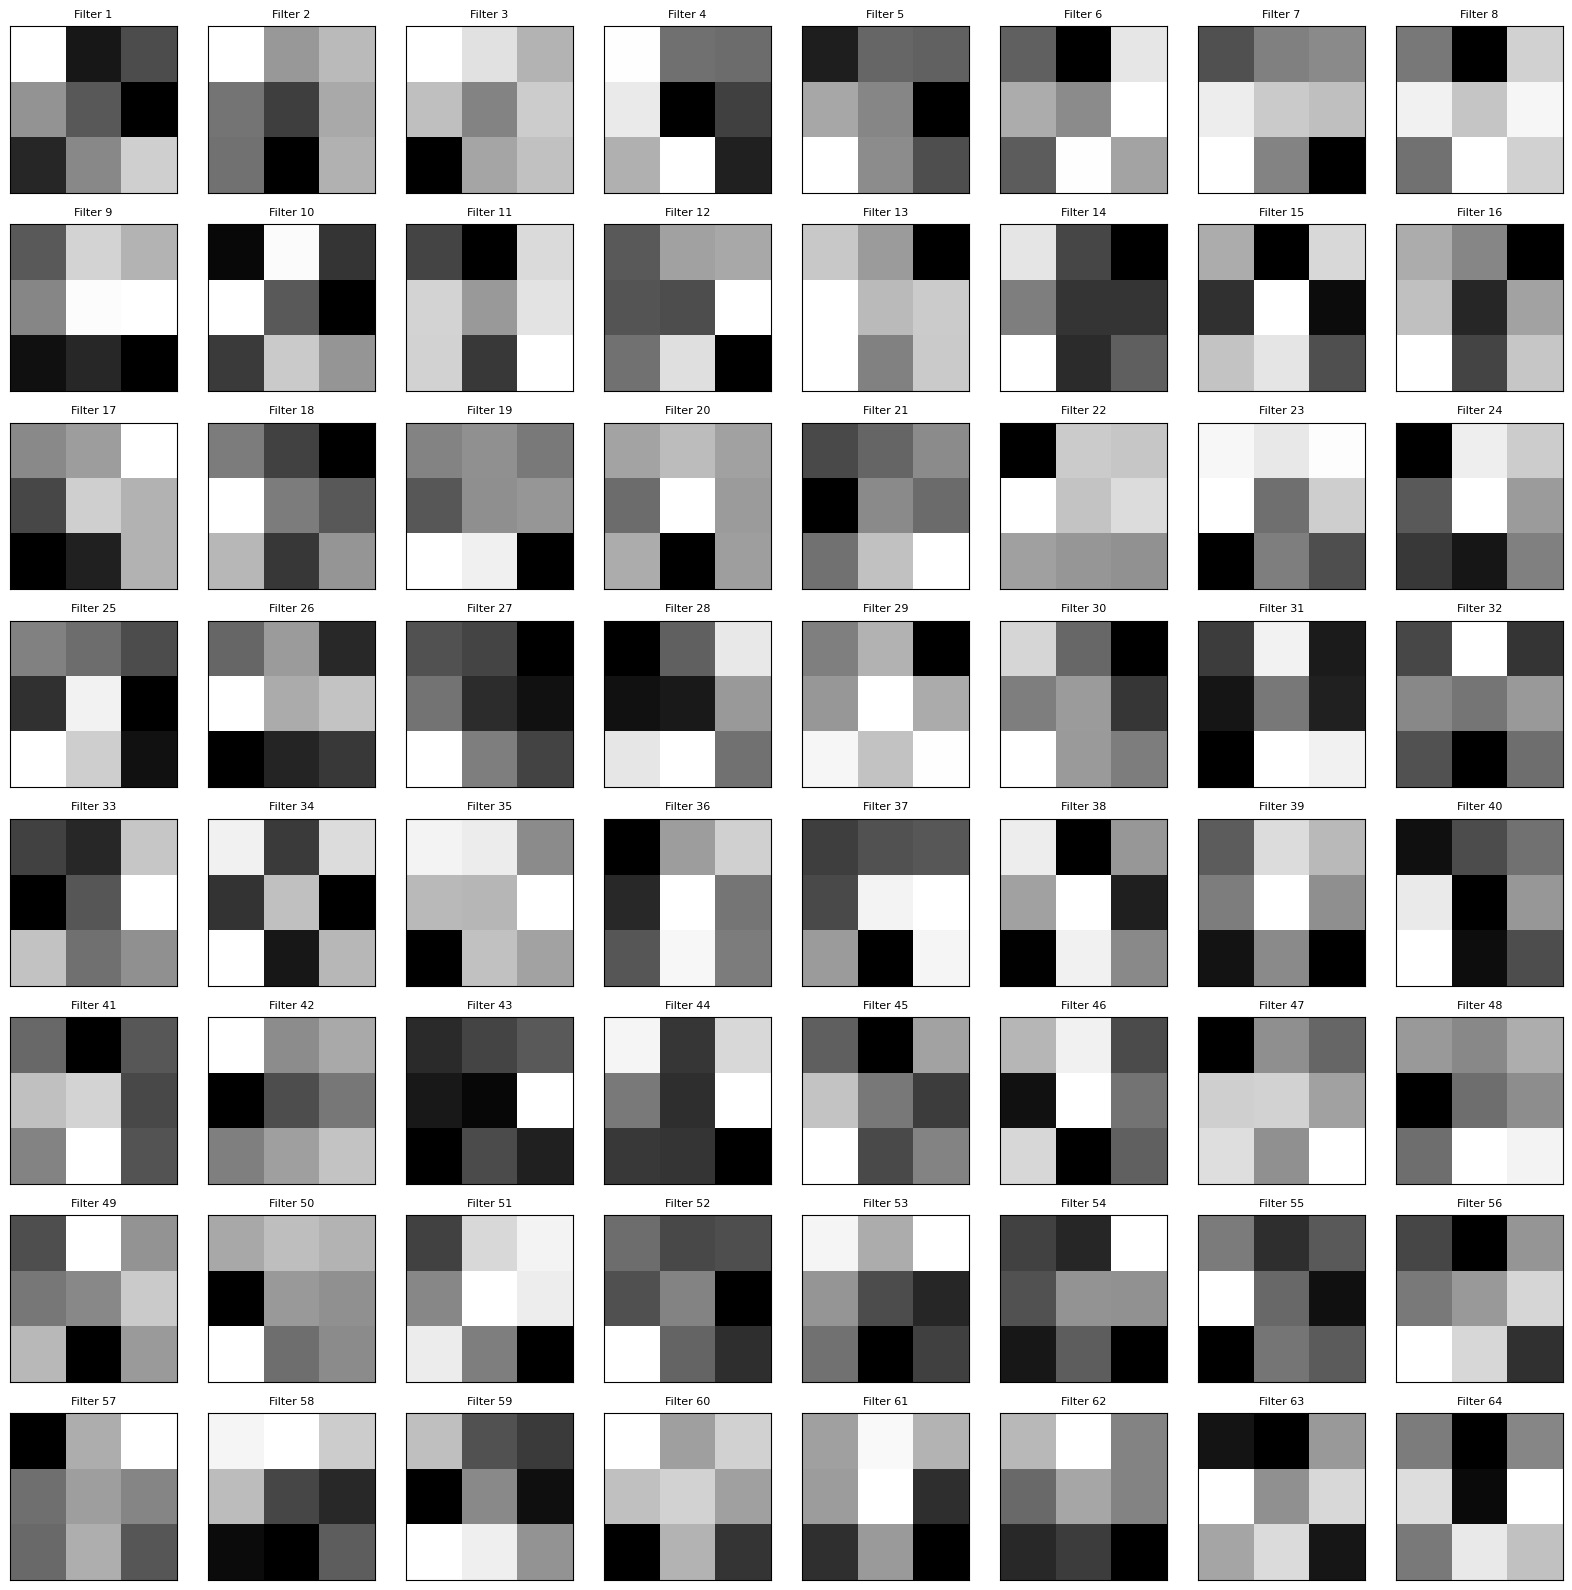

Layer name: conv2d_5, Filters shape: (3, 3, 128, 128), Biases shape: (128,)


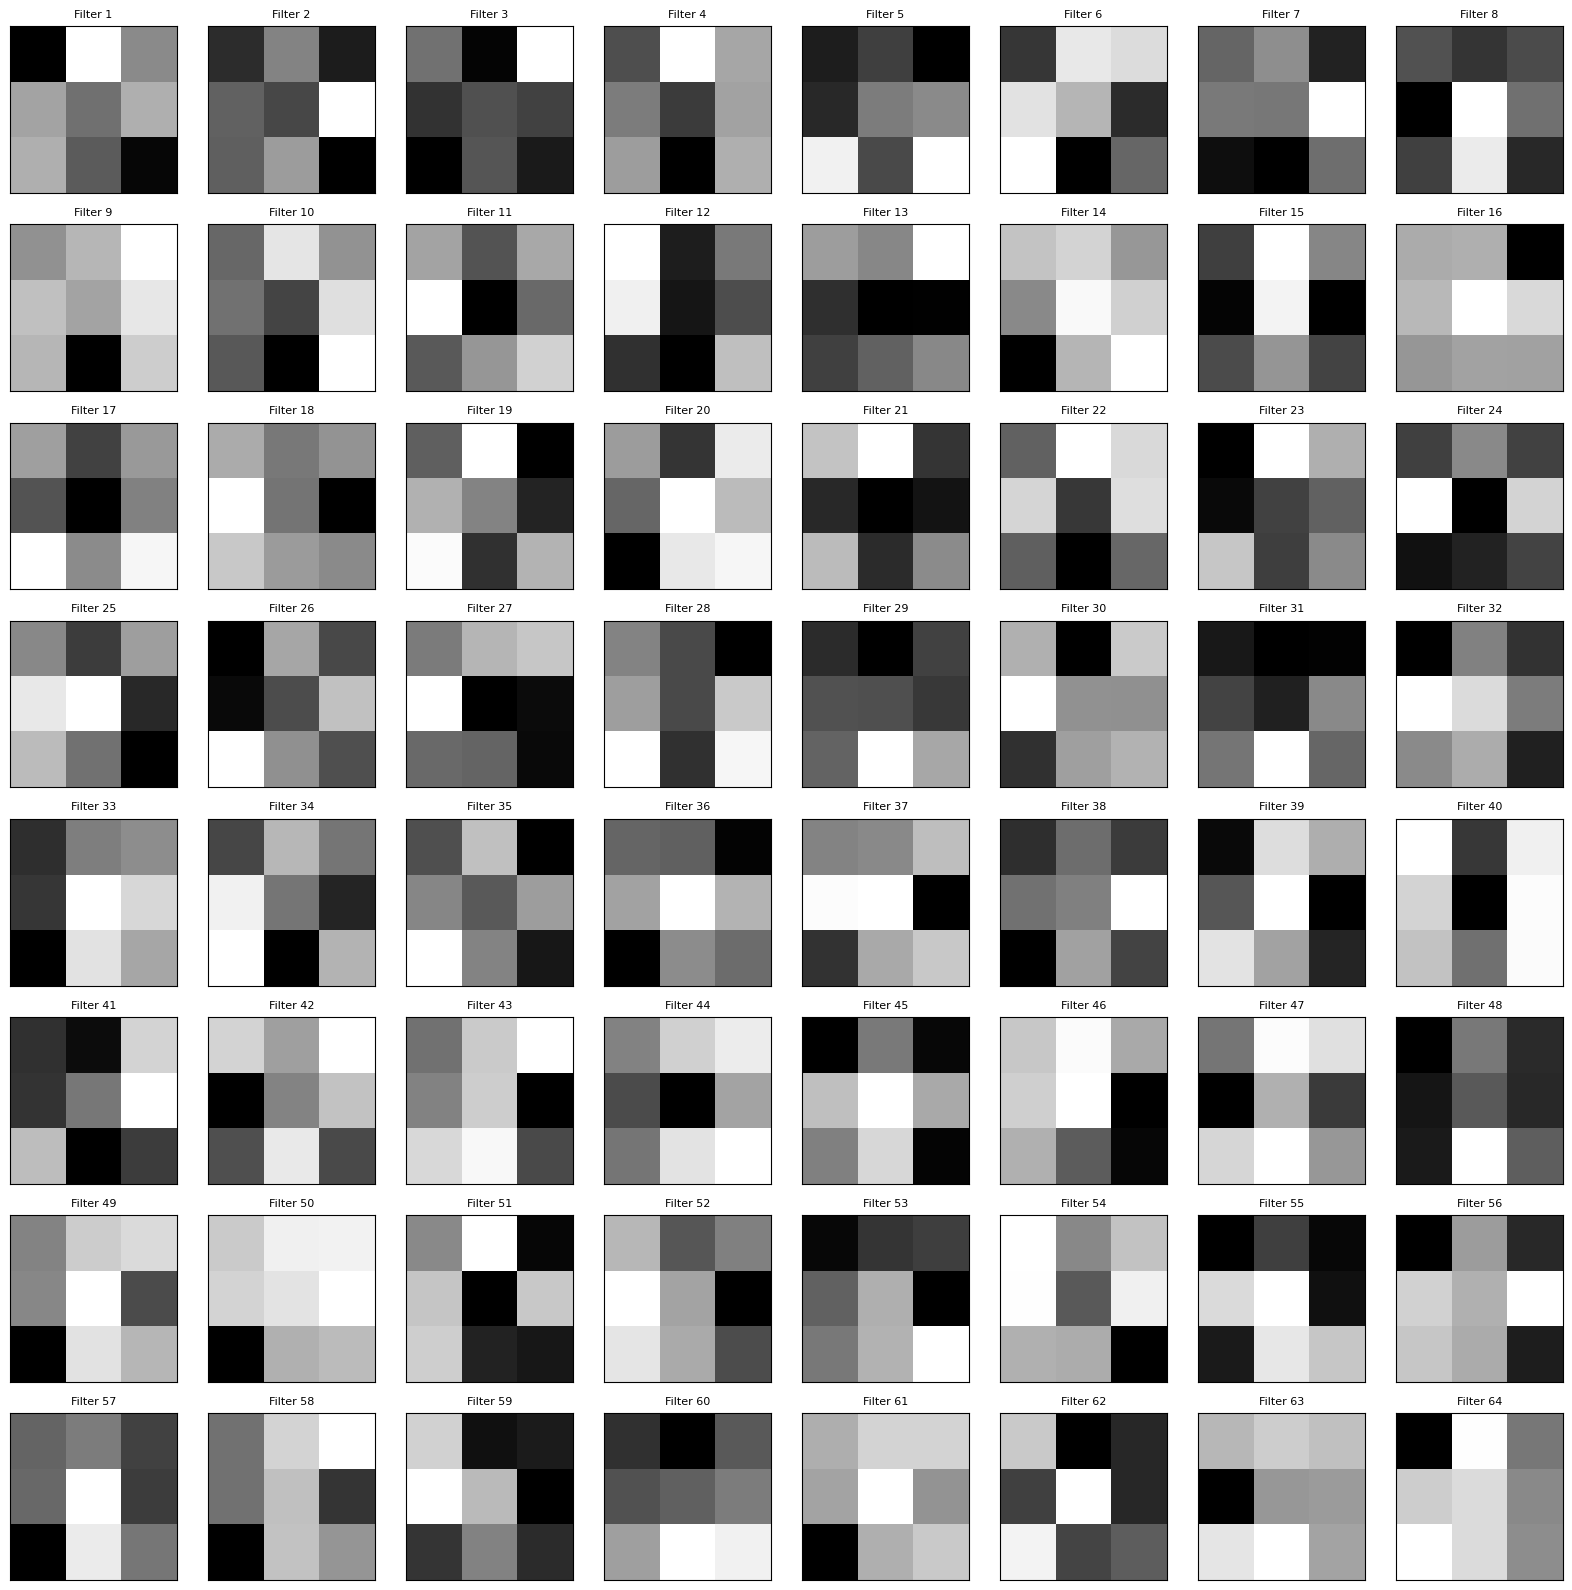

In [42]:
# Iterate through all layers in the model
for layer in model_for_feature_maps.layers:
    # Check if the layer is a Conv2D layer
    if isinstance(layer, Conv2D):
        # Get the filters and biases
        filters, biases = layer.get_weights()
        
        # Print the name of the layer and the shape of the filters
        print(f"Layer name: {layer.name}, Filters shape: {filters.shape}, Biases shape: {biases.shape}")
        plot_convolutional_layer_filters(filters)

In [44]:
conv_layer_index = [1, 3, 5]
outputs = [model_for_feature_maps.layers[i].output for i in conv_layer_index]

model_short = Model(inputs = model_for_feature_maps.inputs, outputs = outputs)
print(model_short.summary())

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,264 (1012.75 KB)

 Trainable params: 259,264 (1012.75 KB)

 Non-trainable params: 0 (0.00 B)

None


We randomly picked an image from the train folder 15_430 to visualize the convolutional layers.

In [45]:
img = load_img(r'15_430.png', target_size=(28,28))

# Convert the image to an array
img_array = img_to_array(img)

# Convert RGB image to grayscale
img_gray = rgb_to_grayscale(img_array)

# Expand dimensions to match the expected input shape (1, 28, 28, 1)
img_gray = np.expand_dims(img_gray, axis=0)

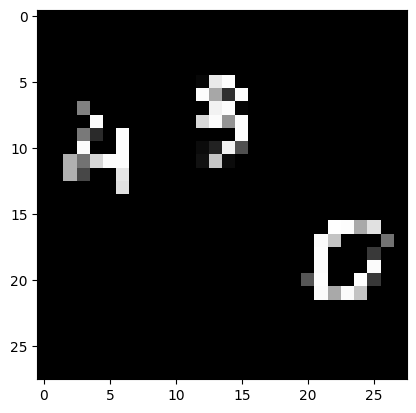

In [46]:
plt.imshow(img, cmap = 'gray')

In [47]:
feature_output = model_short.predict(img_gray)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


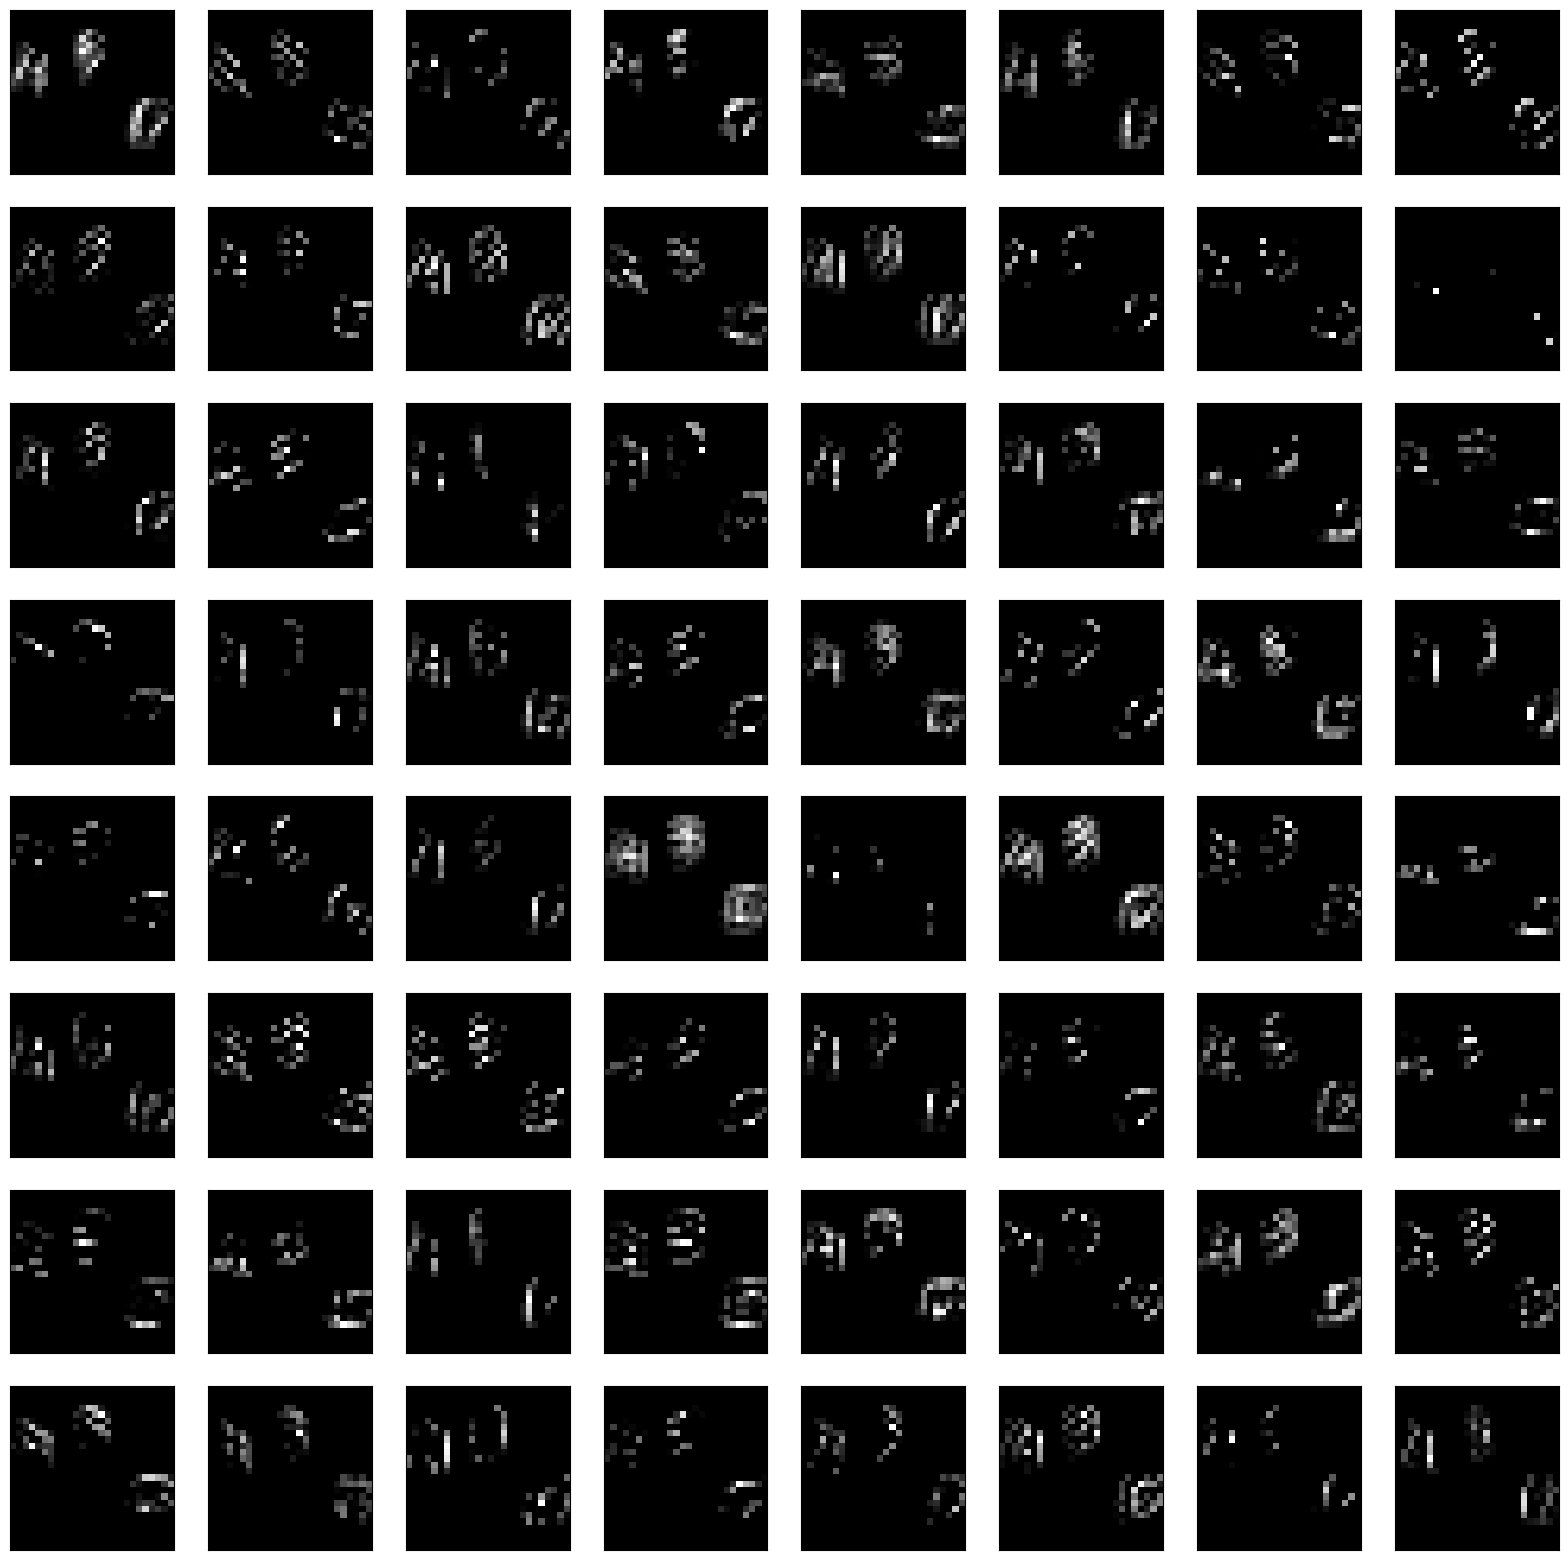

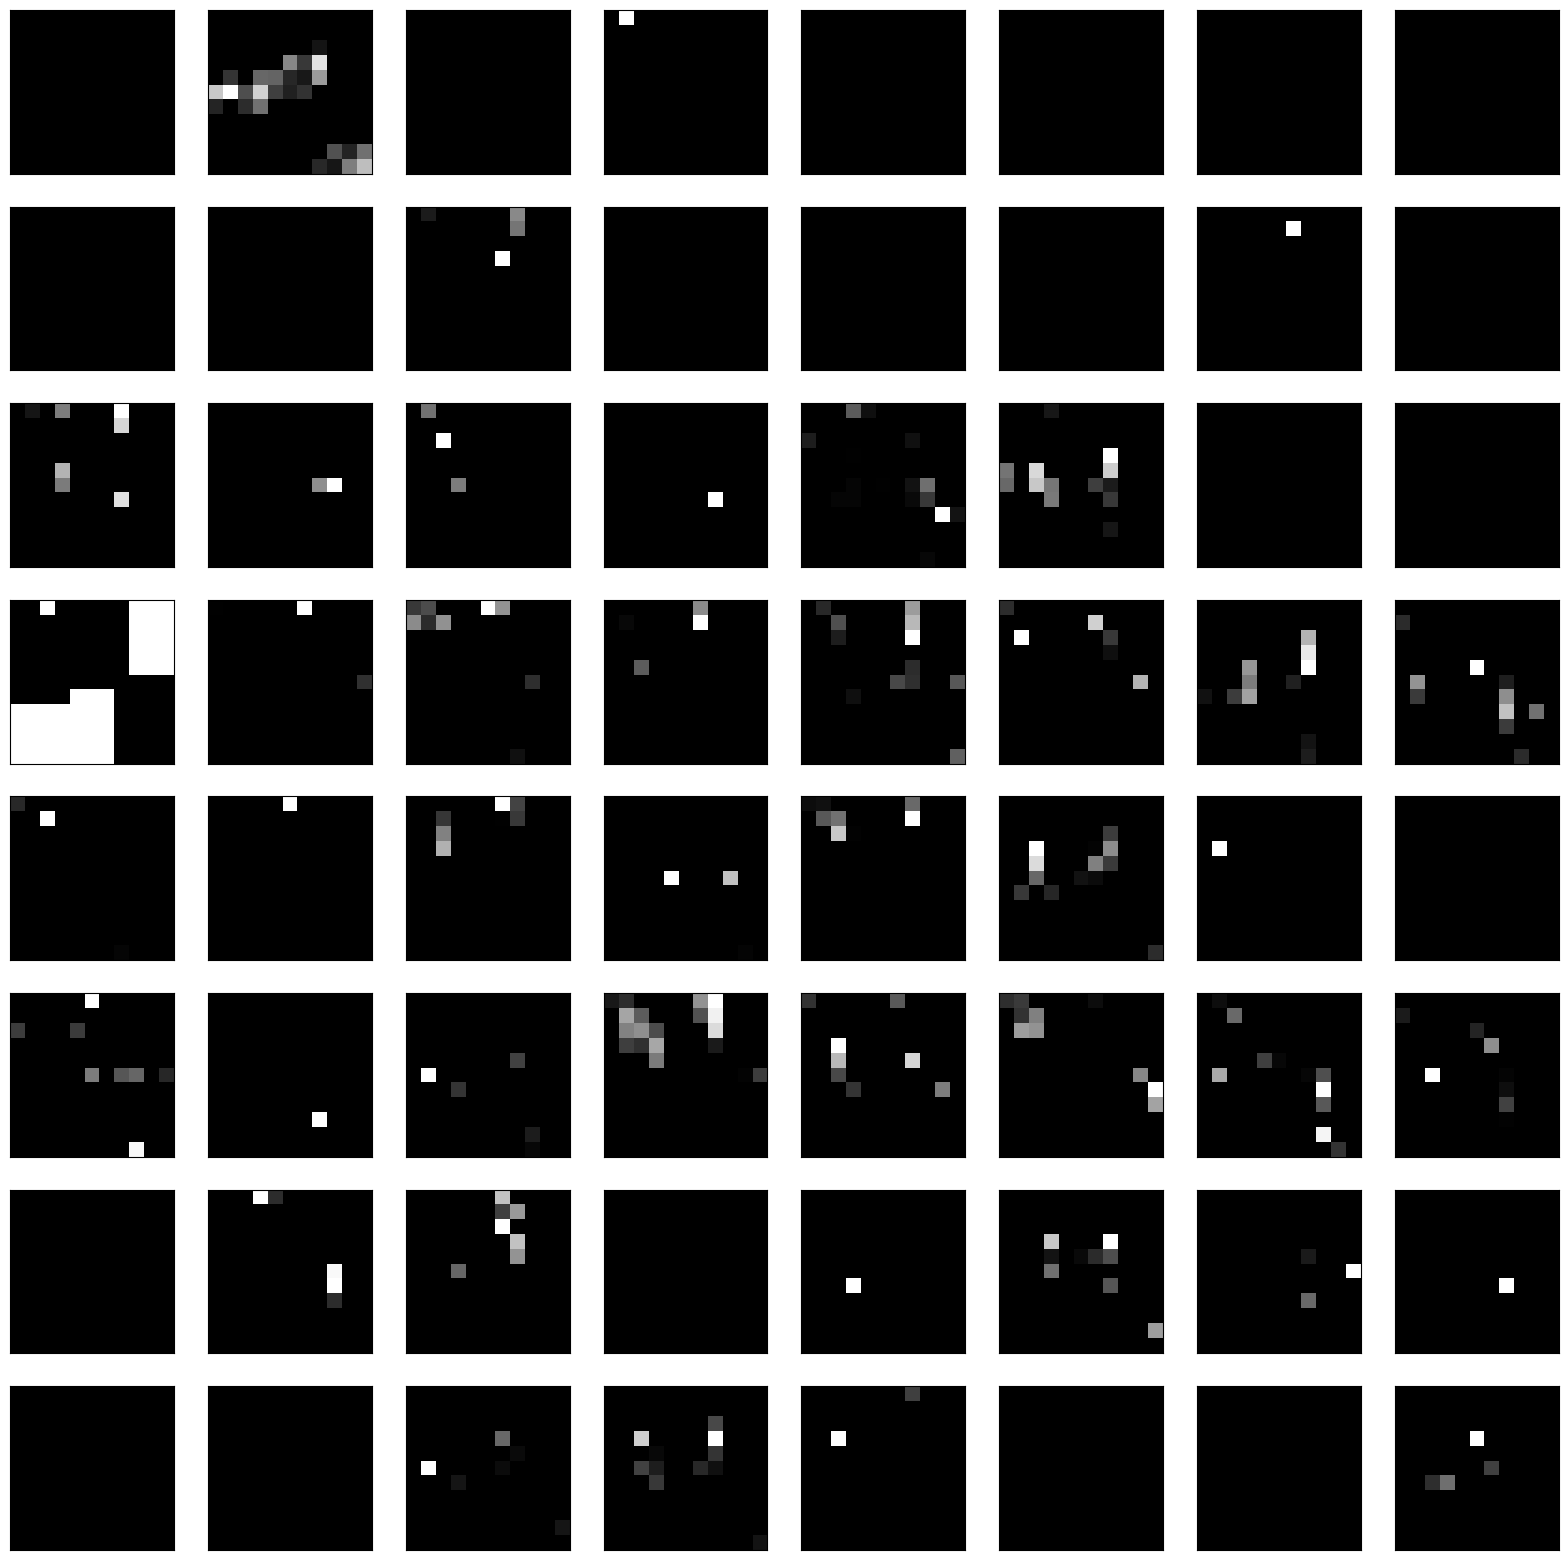

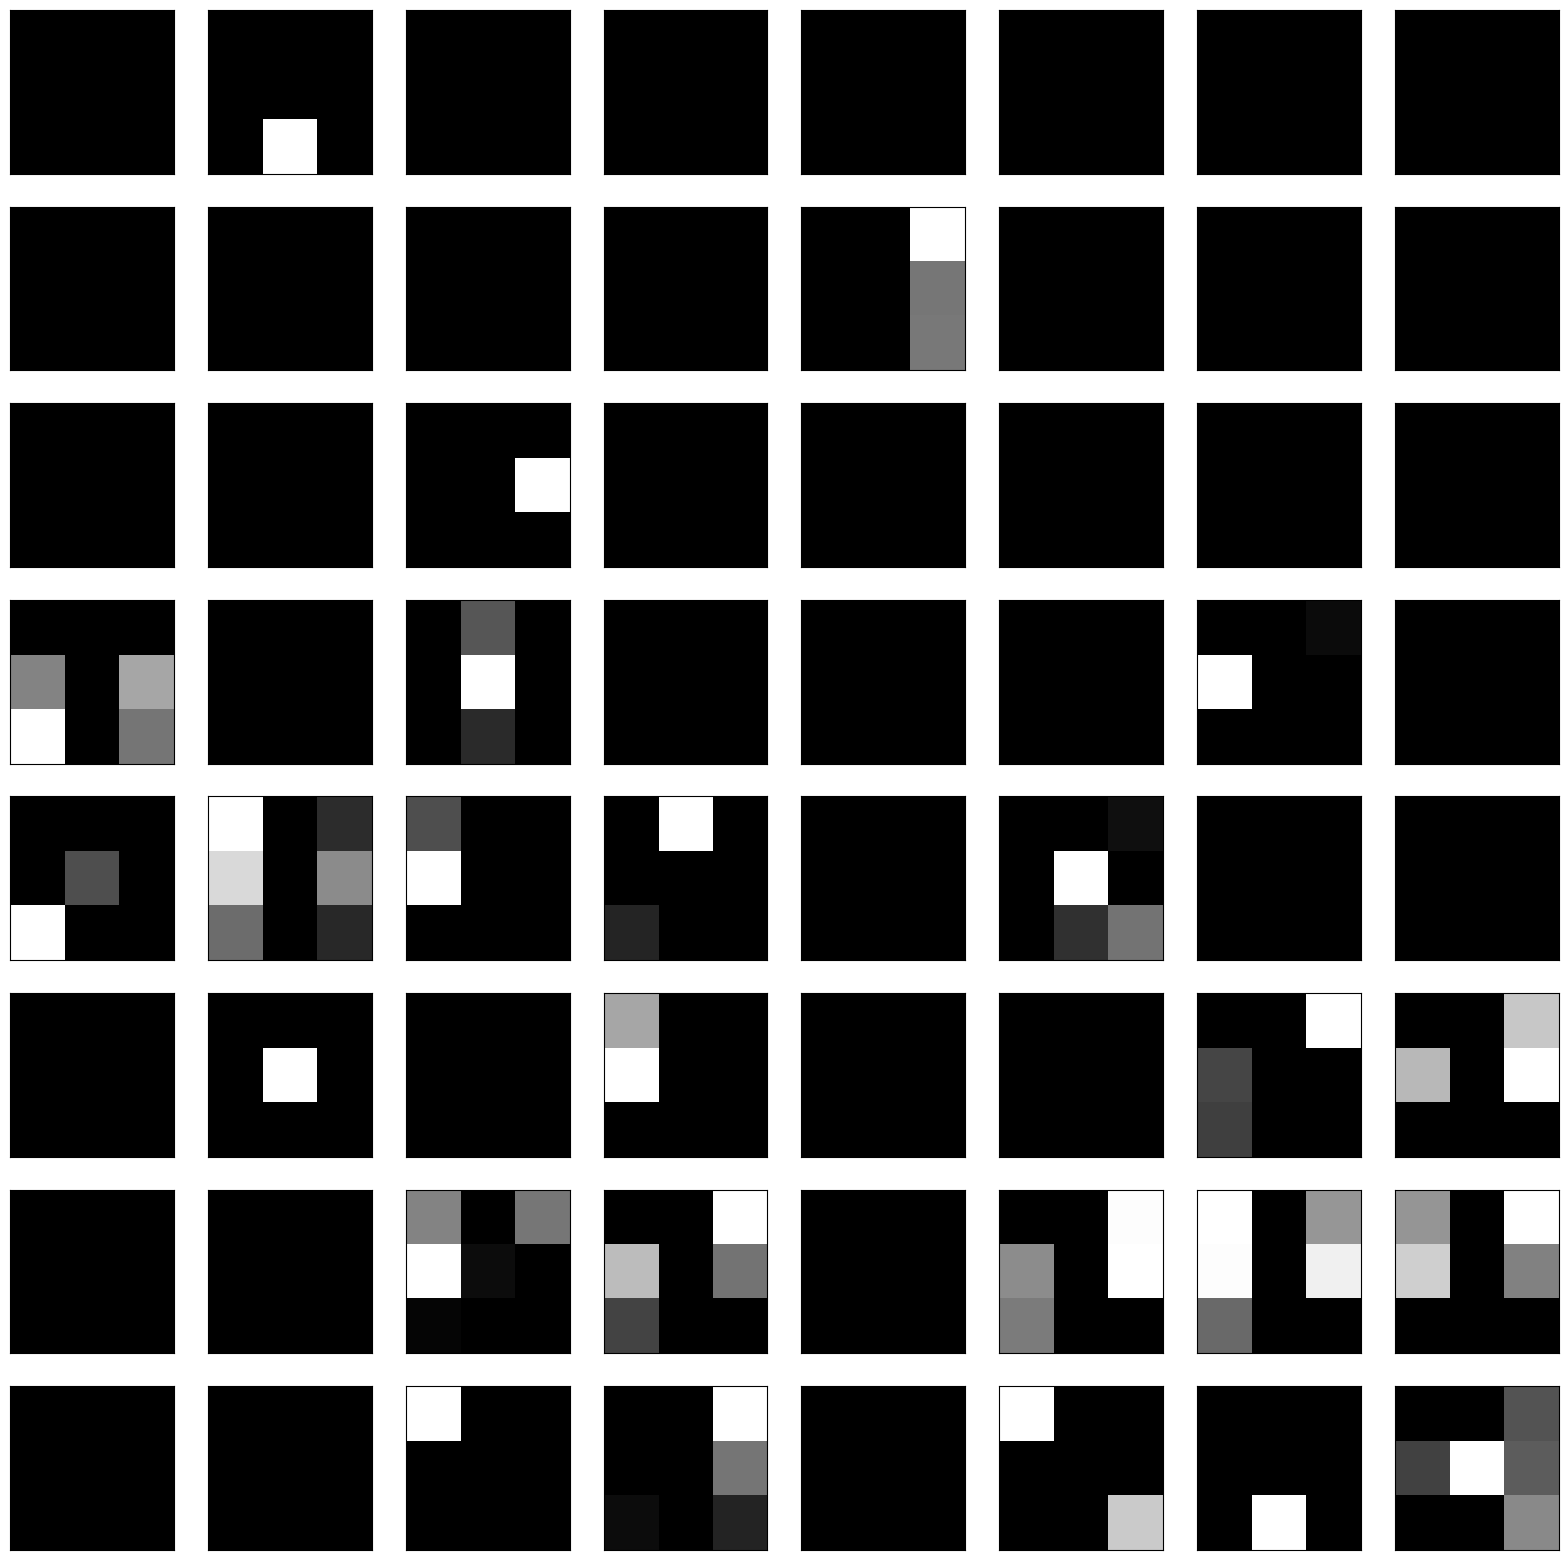

In [48]:
columns = 8
rows = 8

for feature in feature_output:
    fig = plt.figure(figsize=(20, 20))
    # max_index = min(columns * rows, feature.shape[3])

    for i in range(1, columns * rows + 1):
        ax = plt.subplot(rows, columns, i)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature[0, :, :, i], cmap='gray')

    plt.show()

The feature maps show how the model was learning.

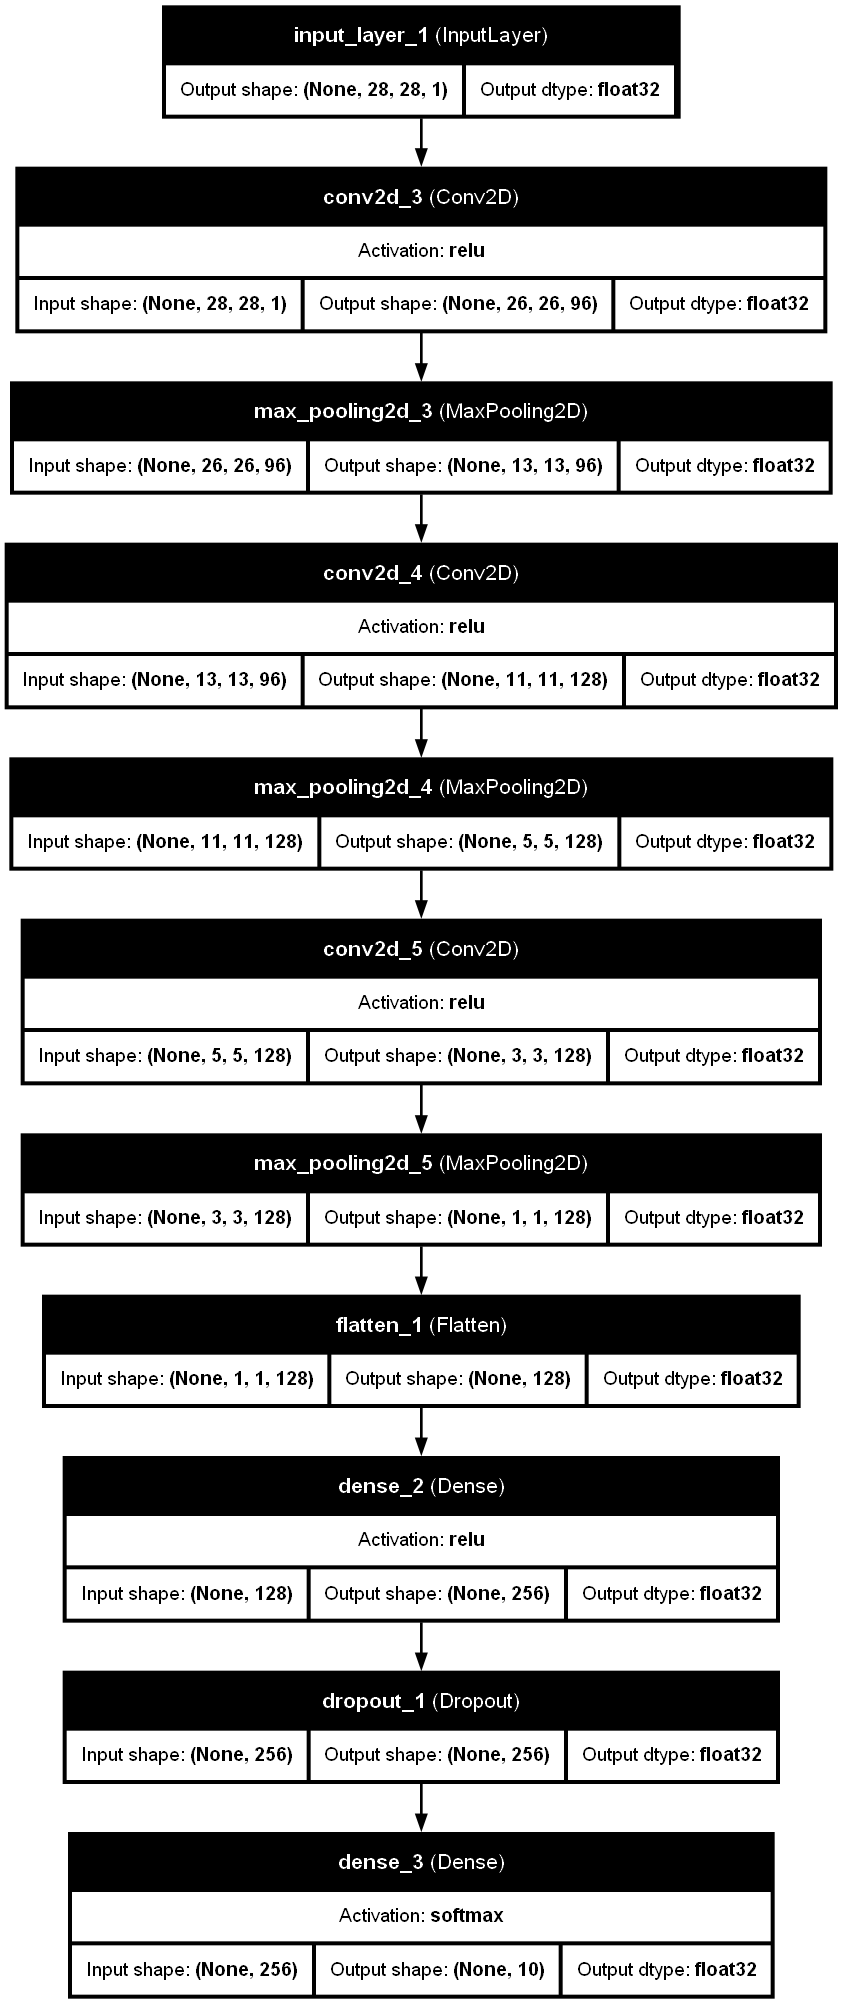

In [49]:
# Visualize the model architecture with more parameters
plot_model(
    model_for_feature_maps,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # 'TB' means top to bottom, 'LR' means left to right
    dpi=96,        # Dots per inch for the output image
    expand_nested=True,  # Expand nested models into clusters in the plot
    show_dtype=True,     # Display layer dtypes
    layer_range=None,    # List of layers to display (None means all layers)
    show_layer_activations=True  # Display layer activation functions
)

#### Saliency maps 

Saliency Maps highlight the most important areas of the input image in pixel level, showing which parts of the input image contribute most to the output prediction. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


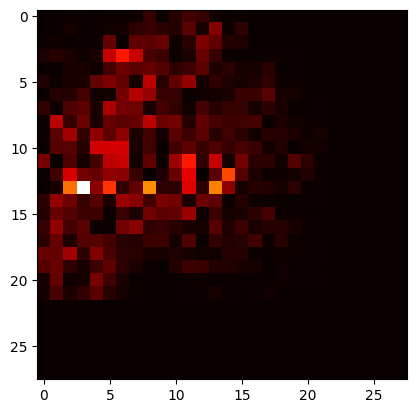

In [50]:
def compute_saliency_map(model, img_array, class_index):
    
    """
    Computes the saliency map for a given image and class index using the provided model.

    Args:
    model (tf.keras.Model): The trained model.
    img_array (np.array): The input image array.
    class_index (int): The index of the class for which the saliency map is computed.

    Returns:
    np.array: The computed saliency map.
    """
    
    # Convert image array to tensor and add batch dimension
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_array = tf.expand_dims(img_array, axis=0)

    # Compute gradients with respect to the input image
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        loss = predictions[:, class_index]

    # Compute gradients
    grads = tape.gradient(loss, img_array)
    
    # Compute saliency map by taking the maximum absolute value across the color channels
    saliency_map = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    return saliency_map.numpy()

img_gray = np.random.rand(28, 28, 1)  
class_index = np.argmax(model_for_feature_maps.predict(tf.expand_dims(img_gray, axis=0)))
saliency_map = compute_saliency_map(model_for_feature_maps, img_gray, class_index)

# Visualize the saliency map
plt.imshow(saliency_map, cmap='hot')
plt.show()

#### Grad-CAM 

Similar purpose with Saliency Map but smoother, Gradcam 
highlight the most important areas of the input image in region level, showing which parts of the input image contribute most to the output prediction.

In [51]:
img_path = '15_430.png'
img = load_img(img_path, color_mode='grayscale', target_size=(28, 28))  # Ensure the image is loaded in grayscale mode
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize

In [52]:
_ = model_for_feature_maps.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [53]:
dummy_input = np.random.random((1, 28, 28, 1))  
model_for_feature_maps.predict(dummy_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[0.04075995, 0.08025955, 0.08070875, 0.06451759, 0.05134074,
        0.02328235, 0.01862155, 0.09172314, 0.44034308, 0.10844327]],
      dtype=float32)

In [54]:
def build_gradcam_model(model, layer_name): #Builds a model that outputs the specified layer and final output.
    
    """
    Builds a model that outputs the activations of a specified layer and the final output of the given model.

    Args:
    model (tf.keras.Model): The original trained model.
    layer_name (str): The name of the layer whose activations are to be extracted.

    Returns:
    tf.keras.Model: A new model that outputs the activations of the specified layer and the final output.
    """
    
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    return grad_model

def compute_gradcam(model, img_array, class_index, layer_name):
    
    """
    Computes the Grad-CAM heatmap for a given image and class index using the specified layer of the model.

    Args:
    model (tf.keras.Model): The trained model.
    img_array (np.array): The input image array.
    class_index (int): The index of the class for which the Grad-CAM heatmap is computed.
    layer_name (str): The name of the layer to use for Grad-CAM.

    Returns:
    np.array: The computed Grad-CAM heatmap.
    """

    grad_model = build_gradcam_model(model, layer_name)
    with tf.GradientTape() as tape:
        # Execute the model to get the outputs and convolutional layer activations
        conv_outputs, predictions = grad_model(img_array)
        # If the model has multiple outputs, ensure to select the correct one
        if isinstance(predictions, list):  # Check if predictions is a list
            predictions = predictions[0]  # Adjust if prediction is at a different index
        # set it to be watched by the gradient tape
        tape.watch(conv_outputs)
        loss = predictions[:, class_index]

    # Compute the gradients of the loss with respect to the conv layer outputs
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the convolutional layer outputs with the computed gradients
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def superimpose_heatmap(img_path, heatmap, alpha=0.4):   
    
    """
    Superimposes a heatmap on the original image.

    Args:
    img_path (str): Path to the original image file.
    heatmap (np.array): The heatmap to be superimposed.
    alpha (float, optional): Weight for the heatmap. Defaults to 0.4.

    Returns:
    np.array: The image with the heatmap superimposed.
    """
    
    img = plt.imread(img_path) #Superimposes the heatmap on the original image
    
    # Ensure the image is in the correct shape and has three channels if it is originally grayscale
    if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Resize heatmap to match the dimensions of the original image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    
    return superimposed_img

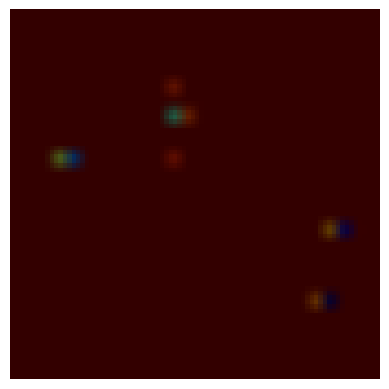

In [59]:
conv_layer_name = 'conv2d_3'  # Adjusted to the actual last convolutional layer name

# Compute the Grad-CAM heatmap using the correct convolutional layer name
heatmap = compute_gradcam(model_for_feature_maps, img_array, class_index, conv_layer_name)
heatmap = np.squeeze(heatmap)  # Remove batch dimension if necessary

# Superimpose the heatmap on the original image
superimposed_img = superimpose_heatmap(img_path, heatmap)

plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

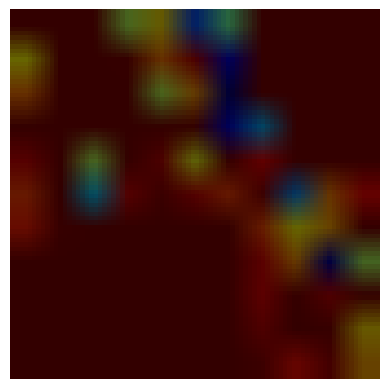

In [60]:
conv_layer_name = 'conv2d_4'  # Adjusted to the actual last convolutional layer name

# Compute the Grad-CAM heatmap using the correct convolutional layer name
heatmap = compute_gradcam(model_for_feature_maps, img_array, class_index, conv_layer_name)
heatmap = np.squeeze(heatmap)  # Remove batch dimension if necessary

# Superimpose the heatmap on the original image
superimposed_img = superimpose_heatmap(img_path, heatmap)

plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

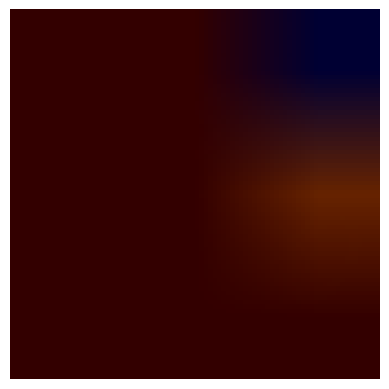

In [61]:
conv_layer_name = 'conv2d_5'  # Adjusted to the actual last convolutional layer name

# Compute the Grad-CAM heatmap using the correct convolutional layer name
heatmap = compute_gradcam(model_for_feature_maps, img_array, class_index, conv_layer_name)
heatmap = np.squeeze(heatmap)  # Remove batch dimension if necessary

# Superimpose the heatmap on the original image
superimposed_img = superimpose_heatmap(img_path, heatmap)

plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

#### Deep Dream

DeepDream visualization takes the input image(s), and enchances the patterns and curves what a netowrk would typically see, and then create a dream-like visuals to showcase the learned features.

In [62]:
def preprocess_image(image_path):

    """
    Preprocesses an image for model input by loading, resizing, and normalizing it.

    Args:
    image_path (str): Path to the image file.

    Returns:
    np.array or None: Preprocessed image array normalized between 0 and 1, or None if an error occurs.
    """

    try:
        img = image.load_img(image_path, color_mode='grayscale', target_size=(28, 28))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0
        return img
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def deprocess_image(img):
    
    """
    Converts a processed image array back to a format suitable for display or saving.

    Args:
    img (np.array): Processed image array with shape (1, height, width, channels).

    Returns:
    np.array: Image array in uint8 format with pixel values in the range [0, 255].
    """

    img = img.reshape((img.shape[1], img.shape[2]))
    img *= 255.0
    img = np.clip(img, 0, 255).astype('uint8')
    return img

def compute_loss(input_image, model):
    
    """
    Computes the loss for the given input image using the specified model.

    Args:
    input_image (tf.Tensor): The input image tensor.
    model (tf.keras.Model): The model used to compute the features.

    Returns:
    tf.Tensor: The computed loss as the mean of the model's output features.
    """
    
    features = model(input_image)
    return tf.reduce_mean(features)

def deepdream(model, img, steps=100, step_size=0.01):
    
    """
    Applies the DeepDream algorithm to a given image using the provided model.

    Args:
    model (tf.keras.Model): The trained model to be used for generating the dream.
    img (np.array): The input image array (normalized between 0 and 1).
    steps (int, optional): The number of optimization steps to perform. Defaults to 100.
    step_size (float, optional): The step size for each gradient update. Defaults to 0.01.

    Returns:
    np.array: The DeepDream image after optimization.
    """
    
    img = tf.convert_to_tensor(img)
    for step in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = compute_loss(img, model)
        gradients = tape.gradient(loss, img)
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        img = img + gradients * step_size
        img = tf.clip_by_value(img, 0, 1)  # Grayscale images range between 0 and 1
    return img

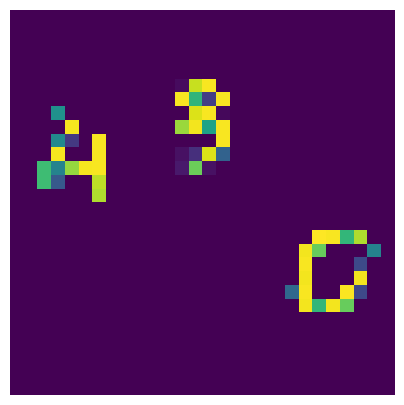

In [63]:
# Load and preprocess the image
image_path = r'15_430.png'
original_img = preprocess_image(image_path)

# Apply DeepDream
dream_img = deepdream(model_for_feature_maps, original_img, steps=100, step_size=0.01)

# De-process the image and display it
dream_img = deprocess_image(dream_img.numpy())
plt.figure(figsize=(5, 5))
plt.imshow(dream_img)
plt.axis('off')
plt.show()

#### Guided Back Propagation 

A technique to visualize neural network activations by modifying backpropagation to highlight important features in input images, enhancing interpretability of CNN models.

In [64]:
def guided_backpropagation(gradient, guided_gradients):

    """
    Applies guided backpropagation to the gradient using the guided gradients.

    Args:
    gradient (tf.Tensor): The gradient tensor from backpropagation.
    guided_gradients (tf.Tensor): The guided gradients tensor, typically obtained from a previous layer.

    Returns:
    tf.Tensor: The modified gradient tensor after applying guided backpropagation.
    """

    return tf.where(guided_gradients > 0, gradient, 0.0)

def get_guided_backpropagation_gradients(model, input_image, target_class):   
    
    """
    Computes the guided backpropagation gradients for a given input image and target class.

    Args:
    model (tf.keras.Model): The model used to generate predictions.
    input_image (tf.Tensor): The input image tensor.
    target_class (int): The index of the target class for which gradients are computed.

    Returns:
    tf.Tensor: The guided backpropagation gradients for the input image.
    """    
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        loss = predictions[0, target_class]

    gradients = tape.gradient(loss, input_image)
    
    # Apply guided backpropagation modification
    guided_gradients = tf.maximum(gradients, 0.0)  # Positive gradients
    gradients = guided_backpropagation(gradients, guided_gradients)

    return gradients

def generate_guided_backpropagation_gradients_saliency_map(model, img_path, target_class):
    
    """
    Generates a saliency map for a given grayscale image using guided backpropagation.

    Args:
    model (tf.keras.Model): The model used for generating gradients.
    img_path (str): Path to the input image file.
    target_class (int): Index of the target class for which the saliency map is generated.
    target_size (tuple): The target size for resizing the image (height, width).

    Returns:
    np.array: The saliency map as a numpy array with values normalized to [0, 1].
    """

    # Preprocess the image
    img = preprocess_image(img_path)

    # Compute the guided backpropagation gradients
    gradients = get_guided_backpropagation_gradients(model, tf.Variable(img, dtype=tf.float32), target_class)
    
    # Post-process gradients to generate the saliency map
    saliency_map = tf.reduce_max(gradients, axis=-1)[0]  # Take the maximum across color channels
    saliency_map = np.maximum(saliency_map, 0)  # Remove negative values
    saliency_map = saliency_map / np.max(saliency_map)  # Normalize to [0, 1]
    
    return saliency_map

def visualize_saliency_map(saliency_map):
    
    """
    Visualizes a saliency map using matplotlib.

    Args:
    saliency_map (np.array): The saliency map to visualize, typically a 2D array.
    """

    plt.figure(figsize=(8, 8))
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')
    plt.title('Guided Backpropagation Saliency Map')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


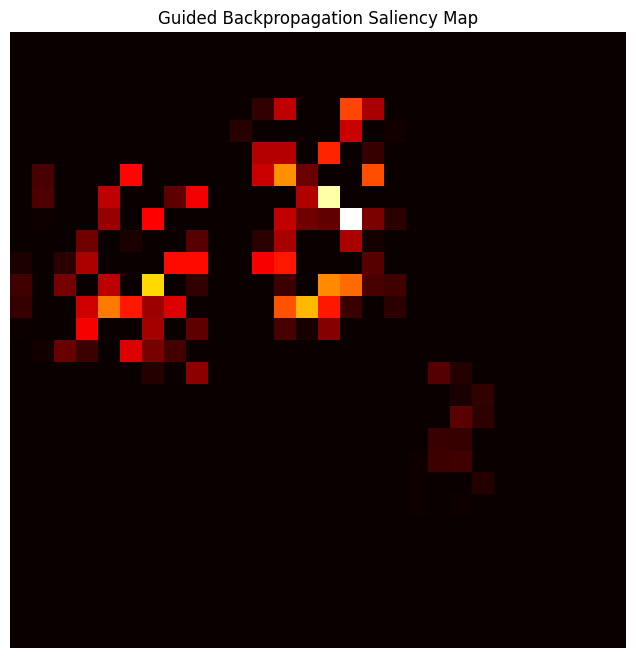

In [70]:
# Define image path and target class index
img_path = r'15_430.png'
target_class = np.argmax(model_for_feature_maps.predict(tf.expand_dims(img_gray, axis=0)))
# Generate saliency map
saliency_map = generate_guided_backpropagation_gradients_saliency_map(model_for_feature_maps, img_path, target_class)

# Visualize the saliency map
visualize_saliency_map(saliency_map)